In [1]:
# If needed (first run):
# !pip install xarray netCDF4 h5py numpy pandas

import os, math, json
import numpy as np
import pandas as pd
import h5py, xarray as xr
from pathlib import Path
from datetime import datetime

# import torch
# import torch.nn as nn
# import torch.nn.functional as F


In [2]:
BASE = Path(r"C:\Users\jr80fd\swin_test")
INSAR_H5 = BASE / "timeseries_ERA5_ramp_demErr.h5"

W3RA_DIR = BASE / "w3ra"
geom_path = Path(r"C:\Users\JR80FD\swin_test\inputs\geometryGeo.h5")


print(f"BASE: {BASE}")
print(f"INSAR_H5: {INSAR_H5}")      

print(f"W3RA_DIR: {W3RA_DIR}")


BASE: C:\Users\jr80fd\swin_test
INSAR_H5: C:\Users\jr80fd\swin_test\timeseries_ERA5_ramp_demErr.h5
W3RA_DIR: C:\Users\jr80fd\swin_test\w3ra


In [3]:
import h5py
from pathlib import Path


def walk_h5(fn):
    with h5py.File(fn, 'r') as f:
        print("HDF5 file:", fn)
        def _walk(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"[DATASET] {name}  shape={obj.shape}  dtype={obj.dtype}")
                for k,v in obj.attrs.items():
                    if k in ("rows","cols","length","mintpy.meta"):  # common MintPy attrs
                        print(f"   attr {k}: {v}")
            elif isinstance(obj, h5py.Group):
                print(f"[GROUP]   {name}")
        f.visititems(_walk)


In [4]:

walk_h5(INSAR_H5)


HDF5 file: C:\Users\jr80fd\swin_test\timeseries_ERA5_ramp_demErr.h5
[DATASET] bperp  shape=(156,)  dtype=float32
[DATASET] date  shape=(156,)  dtype=|S8
[DATASET] timeseries  shape=(156, 2939, 3713)  dtype=float32


# 1) Inspect the InSAR HDF5 structure

In [5]:
def summarize_h5(path):
    with h5py.File(path, "r") as f:
        print(f"File: {path}")
        print("Top-level keys:", list(f.keys()))
        for k in f.keys():
            obj = f[k]
            if isinstance(obj, h5py.Dataset):
                print(f"  Dataset: {k:18s} shape={obj.shape} dtype={obj.dtype}")
                if obj.attrs:
                    a = {k2: obj.attrs[k2] for k2 in obj.attrs.keys()}
                    print("    attrs keys:", list(a.keys())[:8])
            else:
                print(f"  Group:   {k}")
        # common MintPy fields
        if "date" in f:
            raw = f["date"][:]
            dates = [d.decode() if isinstance(d, (bytes, np.bytes_)) else str(d) for d in raw]
            print(f"\nFound {len(dates)} dates. First/last: {dates[:3]} ... {dates[-3:]}")
        if "timeseries" in f:
            print("timeseries shape:", f["timeseries"].shape)


In [6]:

summarize_h5(INSAR_H5)


File: C:\Users\jr80fd\swin_test\timeseries_ERA5_ramp_demErr.h5
Top-level keys: ['bperp', 'date', 'timeseries']
  Dataset: bperp              shape=(156,) dtype=float32
  Dataset: date               shape=(156,) dtype=|S8
  Dataset: timeseries         shape=(156, 2939, 3713) dtype=float32

Found 156 dates. First/last: ['20170610', '20170622', '20170704'] ... ['20220912', '20221006', '20221018']
timeseries shape: (156, 2939, 3713)


# 2) Load InSAR as an xarray.DataArray [time, y, x]

In [7]:
def load_insar_h5_as_xarray(path: Path) -> xr.DataArray:
    with h5py.File(path, "r") as f:
        # dates
        if "date" not in f:
            raise ValueError("No 'date' dataset found in HDF5.")
        raw = f["date"][:]
        dates = [d.decode() if isinstance(d, (bytes, np.bytes_)) else str(d) for d in raw]
        # MintPy often uses YYYYMMDD
        time = pd.to_datetime(dates, format="%Y%m%d", errors="coerce")
        # data
        ts = f["timeseries"][:]  # either (T,H,W) or (H,W,T)
        if ts.ndim != 3:
            raise ValueError("Expected 3D timeseries.")
        # infer axis order
        T, H, W = None, None, None
        if ts.shape[0] == len(time):        # (T,H,W)
            T, H, W = ts.shape
            data = ts
        elif ts.shape[-1] == len(time):     # (H,W,T)
            H, W, T = ts.shape
            data = np.transpose(ts, (2,0,1))   # -> (T,H,W)
        else:
            raise ValueError("Could not infer time axis. Check shapes/dates.")

        # build y/x coords (try attributes, else pixel indices)
        H5_attrs = f["timeseries"].attrs
        def get_attr(name, default=None):
            return H5_attrs[name] if name in H5_attrs else default

        # MintPy geocoded often has: X_FIRST, Y_FIRST, X_STEP, Y_STEP (lon/lat grid)
        x_first = get_attr("X_FIRST", None)
        y_first = get_attr("Y_FIRST", None)
        x_step  = get_attr("X_STEP", None)
        y_step  = get_attr("Y_STEP", None)
        if None not in (x_first, y_first, x_step, y_step):
            x = x_first + np.arange(W) * x_step
            y = y_first + np.arange(H) * y_step
        else:
            # fallback pixel indices
            x = np.arange(W)
            y = np.arange(H)

    da = xr.DataArray(
        data,
        dims=("time","y","x"),
        coords={"time": time, "y": y, "x": x},
        name="insar_deformation"
    )
    return da


In [8]:

insar_da = load_insar_h5_as_xarray(INSAR_H5)
insar_da


<xarray.DataArray 'insar_deformation' (time: 156, y: 2939, x: 3713)> Size: 7GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2017-06-10 2017-06-22 ... 2022-10-18
  * y        (y) int32 12kB 0 1 2 3 4 5 6 ... 2932 2933 2934 2935 2936 2937 2938
  * x        (x) int32 15kB 0 1 2 3 4 5 6 ... 3706 3707 3708 3709 3710 3711 3712

# 3) Inspect W3RA NetCDFs and pick variable names

In [9]:
import xarray as xr
from pathlib import Path


for name in ["W3RA_2010_2024_.nc", "W3RA_2010_2024.nc"]:
    p = W3RA_DIR / name
    try:
        ds = xr.open_dataset(p)
        print("\n---", name, "---")
        print("vars:", list(ds.data_vars)[:10])
        print("dims:", dict(ds.dims))
        if "time" in ds:
            print("time:", str(ds.time.values[:3]), "…", str(ds.time.values[-3:]), f"({ds.dims['time']} steps)")
        ds.close()
    except Exception as e:
        print("\n---", name, "---\n", e)



--- W3RA_2010_2024_.nc ---
vars: ['S0_EU_2010', 'Sd_EU_2010', 'Sg_EU_2010', 'Sr_EU_2010', 'Ss_EU_2010', 'Ssnow_EU_2010', 'Stot_EU_2010', 'S0_EU_2011', 'Sd_EU_2011', 'Sg_EU_2011']
dims: {'lat': 22, 'lon': 24, 'time_2010': 365, 'time_2011': 365, 'time_2012': 366, 'time_2013': 365, 'time_2014': 365, 'time_2015': 365, 'time_2016': 366, 'time_2017': 365, 'time_2018': 365, 'time_2019': 365, 'time_2020': 366, 'time_2021': 365, 'time_2022': 365, 'time_2023': 365, 'time_2024': 213}

--- W3RA_2010_2024.nc ---
vars: []
dims: {'lat': 22, 'lon': 24}


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_7296\4106634407.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("dims:", dict(ds.dims))
C:\Users\JR80FD\AppData\Local\Temp\ipykernel_7296\4106634407.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("dims:", dict(ds.dims))


In [10]:
import xarray as xr
from pathlib import Path

# --- open dataset ---
ds = xr.open_dataset(W3RA_DIR / "W3RA_2010_2024_.nc")

# --- map variable names to standard keys ---
name_map = {}
for k in list(ds.data_vars):
    kl = k.lower()
    if "sg" in kl: name_map["Sg"] = k      # groundwater
    if "sd" in kl: name_map["Sd"] = k      # deep soil
    if "ss" in kl: name_map["Ss"] = k      # shallow soil
    if "s0" in kl or "stot0" in kl: name_map["S0"] = k  # top soil
    if "sr" in kl: name_map["Sr"] = k      # surface water

# --- extract them ---
sg_all = ds[name_map["Sg"]]
sd_all = ds[name_map["Sd"]]
ss_all = ds[name_map["Ss"]]
s0_all = ds[name_map["S0"]]
sr_all = ds[name_map["Sr"]]

print("Picked:", name_map)
print("Shapes:", sg_all.shape, sd_all.shape, ss_all.shape, s0_all.shape, sr_all.shape)

# --- stack into one 4D DataArray: (time, lat, lon, layer) ---
w3ra_all = xr.concat(
    [s0_all, ss_all, sd_all, sg_all, sr_all],
    dim="layer"
)
w3ra_all = w3ra_all.assign_coords(layer=["S0","Ss","Sd","Sg","Sr"])

print("Stacked:", w3ra_all.shape)  # expect (time, lat, lon, 5)

ds.close()


Picked: {'S0': 'S0_EU_2024', 'Sd': 'Sd_EU_2024', 'Sg': 'Sg_EU_2024', 'Sr': 'Sr_EU_2024', 'Ss': 'Ssnow_EU_2024'}
Shapes: (213, 22, 24) (213, 22, 24) (213, 22, 24) (213, 22, 24) (213, 22, 24)
Stacked: (5, 213, 22, 24)


Stitch W3RA years into continuous time series

In [11]:
import xarray as xr
import pandas as pd
import re
from pathlib import Path



def stitch_years(ds, base_prefix):
    """
    Collect variables like f'{base_prefix}_{YYYY}' each with dim 'time_YYYY',
    rename that dim to 'time', cast to datetime, then concat over time.
    Returns a single DataArray with dims (time, lat, lon).
    """
    pats = []
    for k in ds.data_vars:
        m = re.fullmatch(fr"{re.escape(base_prefix)}_(\d{{4}})", k)
        if m: pats.append((int(m.group(1)), k))
    if not pats:
        raise ValueError(f"No yearly vars found for prefix {base_prefix}")
    pats.sort()  # by year
    chunks = []
    for year, var in pats:
        da = ds[var]
        time_dim = f"time_{year}"
        if time_dim not in da.dims:
            raise ValueError(f"{var} missing dim {time_dim}")
        da = da.rename({time_dim: "time"})
        # ensure datetime64
        da = da.assign_coords(time=pd.to_datetime(da['time'].values))
        chunks.append(da)
    out = xr.concat(chunks, dim="time")
    return out


In [12]:
# Stitch each layer across years
s0_all = stitch_years(ds, "S0_EU")
ss_all = stitch_years(ds, "Ss_EU")
sd_all = stitch_years(ds, "Sd_EU")
sg_all = stitch_years(ds, "Sg_EU")
sr_all = stitch_years(ds, "Sr_EU")

print("Shapes:", s0_all.shape, ss_all.shape, sd_all.shape, sg_all.shape, sr_all.shape)

# Stack into one DataArray
w3ra_all = xr.concat([s0_all, ss_all, sd_all, sg_all, sr_all], dim="layer")
w3ra_all = w3ra_all.assign_coords(layer=["S0","Ss","Sd","Sg","Sr"])

print("Stacked:", w3ra_all.shape)  # expect (time, lat, lon, 5)


Shapes: (5326, 22, 24) (5326, 22, 24) (5326, 22, 24) (5326, 22, 24) (5326, 22, 24)
Stacked: (5, 5326, 22, 24)


# 4) Align the time window to your InSAR 
(2017-06-10 → 2022-10-18) and monthly resample

In [13]:
# InSAR time window (from your HDF5 summary)
tmin_insar = pd.Timestamp("2017-06-01")
tmax_insar = pd.Timestamp("2022-10-31")

# Resample each W3RA component to monthly means
s0_m = s0_all.resample(time="MS").mean()
ss_m = ss_all.resample(time="MS").mean()
sd_m = sd_all.resample(time="MS").mean()
sg_m = sg_all.resample(time="MS").mean()
sr_m = sr_all.resample(time="MS").mean()

# Subset to InSAR time window
s0_m = s0_m.sel(time=slice(tmin_insar, tmax_insar))
ss_m = ss_m.sel(time=slice(tmin_insar, tmax_insar))
sd_m = sd_m.sel(time=slice(tmin_insar, tmax_insar))
sg_m = sg_m.sel(time=slice(tmin_insar, tmax_insar))
sr_m = sr_m.sel(time=slice(tmin_insar, tmax_insar))

print("Shapes:",
      s0_m.shape, ss_m.shape, sd_m.shape, sg_m.shape, sr_m.shape)

# Stack back into single 4D DataArray
w3ra_m = xr.concat([s0_m, ss_m, sd_m, sg_m, sr_m], dim="layer")
w3ra_m = w3ra_m.assign_coords(layer=["S0","Ss","Sd","Sg","Sr"])

print("Stacked W3RA monthly:", w3ra_m.shape)  # expect (time, lat, lon, 5)


Shapes: (65, 22, 24) (65, 22, 24) (65, 22, 24) (65, 22, 24) (65, 22, 24)
Stacked W3RA monthly: (5, 65, 22, 24)


# 5) Build InSAR xarray with lat/lon from HDF5 attrs (1D grid)

In [14]:
import h5py, numpy as np, xarray as xr, pandas as pd
from pathlib import Path


with h5py.File(INSAR_H5, "r") as f:
    ts = f["timeseries"][:]             # (T,H,W)
    raw_dates = [d.decode() for d in f["date"][:]]
    time = pd.to_datetime(raw_dates, format="%Y%m%d")
    attrs = f["timeseries"].attrs
    X_FIRST = attrs.get("X_FIRST", None)
    Y_FIRST = attrs.get("Y_FIRST", None)
    X_STEP  = attrs.get("X_STEP",  None)
    Y_STEP  = attrs.get("Y_STEP",  None)

T,H,W = ts.shape
insar_da = xr.DataArray(ts, dims=("time","y","x"),
                        coords={"time": time,
                                "y": np.arange(H),
                                "x": np.arange(W)},
                        name="insar_deformation")

# If geocoded attrs are present, add lon/lat 1D coords
if None not in (X_FIRST, X_STEP, Y_FIRST, Y_STEP):
    lon_1d = X_FIRST + np.arange(W) * X_STEP
    lat_1d = Y_FIRST + np.arange(H) * Y_STEP
    insar_da = insar_da.assign_coords(lon=("x", lon_1d), lat=("y", lat_1d))

# Resample to monthly means and subset
insar_m = insar_da.resample(time="MS").mean().sel(time=slice(tmin_insar, tmax_insar))
print("InSAR monthly shape:", insar_m.shape)


InSAR monthly shape: (65, 2939, 3713)


In [15]:
import h5py
from pathlib import Path


with h5py.File(INSAR_H5, "r") as g:
    print("Top-level datasets:", list(g.keys()))           # e.g., ['latitude','longitude',...]
    for k in ["latitude","longitude","y","x","azimuthCoord","rangeCoord"]:
        if k in g:
            print(k, g[k].shape, g[k].dtype)
    # global attrs can carry projection info (EPSG/UTM zone)
    print("attrs:", {a: g.attrs[a] for a in g.attrs.keys()})


Top-level datasets: ['bperp', 'date', 'timeseries']
attrs: {'ALOOKS': '4', 'ANTENNA_SIDE': '-1', 'AZIMUTH_PIXEL_SIZE': '56.4', 'BANDS': '1', 'CENTER_LINE_UTC': '19151.797495', 'DATA_TYPE': 'float32', 'DATE12': '170610-170622', 'EARTH_RADIUS': '6367896.9087', 'END_DATE': '20221018', 'EPSG': '32633', 'FILE_LENGTH': '2945', 'FILE_PATH': '/mnt/data/aoi_3_02_bologna/MintPy/timeseries_ERA5_ramp_demErr.h5', 'FILE_TYPE': 'timeseries', 'HEADING': '-165.9793419', 'HEIGHT': '701867.9117', 'INTERLEAVE': 'BSQ', 'LAT_REF1': '5011480.0', 'LAT_REF2': '5011480.0', 'LAT_REF3': '4775880.0', 'LAT_REF4': '4775880.0', 'LENGTH': '2939', 'LON_REF1': '413880.0', 'LON_REF2': '116360.0', 'LON_REF3': '413880.0', 'LON_REF4': '116360.0', 'NO_DATA_VALUE': '0.0', 'NoDataValue': '0.0', 'ORBIT_DIRECTION': 'DESCENDING', 'PLATFORM': 'Sen', 'PROCESSOR': 'hyp3', 'PROJECT_NAME': 'mintpy_config', 'P_BASELINE_BOTTOM_HDR': '-3.725', 'P_BASELINE_TOP_HDR': '-3.725', 'RANGE_PIXEL_SIZE': '46.0', 'REF_DATE': '20220103', 'REF_LAT': 

In [21]:
import h5py
with h5py.File(INSAR_H5, "r") as f:
    A = f["timeseries"].attrs
    print({k: A[k] for k in ["EPSG","X_FIRST","X_STEP","X_UNIT","Y_FIRST","Y_STEP","Y_UNIT"] if k in A})


{}


In [17]:
import numpy as np
import h5py
from pyproj import Transformer

# ------------- get UTM grid from geometryGeo.h5 -------------
geom_path = r"C:\Users\JR80FD\swin_test\inputs\geometryGeo.h5"
with h5py.File(geom_path, "r") as g:
    EPSG = int(g.attrs.get("EPSG", 32633))           # 32633 = UTM 33N
    X_FIRST = float(g.attrs["X_FIRST"])              # meters
    X_STEP  = float(g.attrs["X_STEP"])               # meters
    Y_FIRST = float(g.attrs["Y_FIRST"])              # meters
    Y_STEP  = float(g.attrs["Y_STEP"])               # meters

H = insar_da.sizes["y"]
W = insar_da.sizes["x"]

# Easting/Northing 1D
x_e = X_FIRST + np.arange(W) * X_STEP                # shape (W,)
y_n = Y_FIRST + np.arange(H) * Y_STEP                # shape (H,)

# 2D mesh in UTM
XX, YY = np.meshgrid(x_e, y_n)                       # (H,W)

# Transform UTM -> lon/lat
to_ll = Transformer.from_crs(EPSG, 4326, always_xy=True)
lon2d, lat2d = to_ll.transform(XX, YY)               # float64 arrays

# keep memory sane
lon2d = lon2d.astype("float32")
lat2d = lat2d.astype("float32")

# Attach as coords to your existing insar_da
insar_da = insar_da.assign_coords(lat=(("y","x"), lat2d),
                                  lon=(("y","x"), lon2d))

# Monthly resample + subset (reuse your existing time window if you defined it)
insar_m = insar_da.resample(time="MS").mean()
insar_m = insar_m.sel(time=slice("2017-06-01", "2022-10-31"))

print("InSAR monthly:", insar_m.shape, "| coords now:", [c for c in insar_m.coords if c in ("lat","lon")])


InSAR monthly: (65, 2939, 3713) | coords now: ['lat', 'lon']


In [18]:
print(INSAR_H5)

C:\Users\jr80fd\swin_test\timeseries_ERA5_ramp_demErr.h5


# 6) Interpolate W3RA → InSAR grid (bilinear)

W3RA is daily (2010–2024).

InSAR is irregular (6/12 days) but you resampled it to monthly means (156 steps for 2017–2022).
Both datasets aligned as 4D tensors

In [ ]:
# Time-align all W3RA components with InSAR
insar_m, s0_m = xr.align(insar_m, s0_m, join="inner")
_, ss_m = xr.align(insar_m, ss_m, join="inner")
_, sd_m = xr.align(insar_m, sd_m, join="inner")
_, sg_m = xr.align(insar_m, sg_m, join="inner")
_, sr_m = xr.align(insar_m, sr_m, join="inner")

# Bilinear interpolation of each layer onto InSAR grid
s0_on_insar = s0_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
ss_on_insar = ss_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
sd_on_insar = sd_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
sg_on_insar = sg_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")
sr_on_insar = sr_m.interp(lat=insar_m["lat"], lon=insar_m["lon"], method="linear")

print("Regridded shapes:",
      s0_on_insar.shape, ss_on_insar.shape, sd_on_insar.shape,
      sg_on_insar.shape, sr_on_insar.shape)

# Stack into one DataArray
w3ra_on_insar = xr.concat(
    [s0_on_insar, ss_on_insar, sd_on_insar, sg_on_insar, sr_on_insar],
    dim="layer"
)
w3ra_on_insar = w3ra_on_insar.assign_coords(layer=["S0","Ss","Sd","Sg","Sr"])

print("Final stacked shape:", w3ra_on_insar.shape)


In [20]:
# Paths
# out_insar = BASE / "insar_aligned.nc"   # already saved earlier
out_w3ra = BASE / "w3ra_on_insar.nc"     # new name to avoid overwriting

# Save InSAR (skip if already saved)
# insar_m.to_netcdf(out_insar)

# Combine all 5 W3RA layers into one Dataset
xr.Dataset({
    "S0": s0_on_insar,
    "Ss": ss_on_insar,
    "Sd": sd_on_insar,
    "Sg": sg_on_insar,
    "Sr": sr_on_insar,
}).to_netcdf(out_w3ra)

print("✅ Saved W3RA:", out_w3ra)


✅ Saved W3RA: C:\Users\jr80fd\swin_test\w3ra_on_insar.nc


In [21]:
print(insar_m.shape, s0_on_insar.shape, ss_on_insar.shape, sd_on_insar.shape, sg_on_insar.shape, sr_on_insar.shape)
print(insar_m.time.equals(sg_on_insar.time),
      insar_m.y.equals(sg_on_insar.y),
      insar_m.x.equals(sg_on_insar.x))


(65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713) (65, 2939, 3713)
True True True


In [22]:
for da,name in [
    (insar_m, "InSAR"),
    (s0_on_insar, "S0"),
    (ss_on_insar, "Ss"),
    (sd_on_insar, "Sd"),
    (sg_on_insar, "Sg"),
    (sr_on_insar, "Sr")
]:
    nan_pct = float(da.isnull().mean().values) * 100
    print(f"{name}: NaN% = {nan_pct:.3f}")


InSAR: NaN% = 15.385
S0: NaN% = 50.911
Ss: NaN% = 50.911
Sd: NaN% = 50.911
Sg: NaN% = 50.911
Sr: NaN% = 50.911


In [23]:
print(pd.Index(insar_m.time.values).difference(sg_on_insar.time.values))


DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [24]:
i,j = insar_m.sizes['y']//2, insar_m.sizes['x']//2
print("center pixel:", float(insar_m.isel(y=i,x=j).std()), 
      float(sg_on_insar.isel(y=i,x=j).std()))


center pixel: 0.01842602901160717 nan


In [25]:
lat,lon = float(insar_m.lat.isel(y=i,x=j)), float(insar_m.lon.isel(y=i,x=j))
print("lat/lon @center:", lat, lon)


lat/lon @center: 44.820499420166016 12.223923683166504


Test the torch and timm

In [1]:
import torch, timm
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("timm:", timm.__version__)


/home/ubuntu/anaconda3/envs/insar_bayes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch: 2.5.1
CUDA available: True
GPU: NVIDIA A40
timm: 1.0.20


# CAN START HERE IF DATA IS SAVED 

Load the data sets

In [1]:
import xarray as xr
from pathlib import Path

BASE = Path("/mnt/data/mcma/01/")  # adjust to your folder

insar = xr.open_dataset(BASE / "insar_aligned.nc")
w3ra  = xr.open_dataset(BASE / "w3ra_on_insar.nc")

print(insar)
print(w3ra)


<xarray.Dataset> Size: 3GB
Dimensions:            (y: 2939, x: 3713, time: 65)
Coordinates:
  * y                  (y) int32 12kB 0 1 2 3 4 5 ... 2934 2935 2936 2937 2938
  * x                  (x) int32 15kB 0 1 2 3 4 5 ... 3708 3709 3710 3711 3712
  * time               (time) datetime64[ns] 520B 2017-06-01 ... 2022-10-01
    lat                (y, x) float32 44MB ...
    lon                (y, x) float32 44MB ...
Data variables:
    insar_deformation  (time, y, x) float32 3GB ...
<xarray.Dataset> Size: 28GB
Dimensions:  (time: 65, y: 2939, x: 3713)
Coordinates:
  * time     (time) datetime64[ns] 520B 2017-06-01 2017-07-01 ... 2022-10-01
    lat      (y, x) float32 44MB ...
    lon      (y, x) float32 44MB ...
  * y        (y) int32 12kB 0 1 2 3 4 5 6 ... 2932 2933 2934 2935 2936 2937 2938
  * x        (x) int32 15kB 0 1 2 3 4 5 6 ... 3706 3707 3708 3709 3710 3711 3712
Data variables:
    S0       (time, y, x) float64 6GB ...
    Ss       (time, y, x) float64 6GB ...
    Sd       (ti

Flatten for Bayesian Model

In [ ]:
# W3RA anomaly computation
w3ra_anom = {}
for var in ["S0","Ss","Sd","Sg","Sr"]:
    da = w3ra[var]
    da_anom = da - da.mean(dim="time")   # anomaly relative to temporal mean
    w3ra_anom[var] = da_anom

# Replace dataset with anomalies
w3ra_anom = xr.Dataset(w3ra_anom)
print(w3ra_anom)


In [ ]:
import numpy as np

# Example: extract for one epoch (t=0)
t = 0
Y_t = insar["insar_deformation"].isel(time=t).values.ravel()   # (P,)
Z_t = np.stack([w3ra_anom[var].isel(time=t).values.ravel() for var in ["S0","Ss","Sd","Sg","Sr"]], axis=-1)  # (P,5)

print("Y_t:", Y_t.shape)
print("Z_t:", Z_t.shape)


In [67]:
import numpy as np
from numpy.linalg import inv, cholesky

# ---------- FFBS for one grid cell (K-dim state, random walk) ----------
def ffbs_one_grid(y, Z, Q, R, m0, P0):
    T, K = Z.shape
    a  = np.zeros((T, K))      # predicted mean
    Rf = np.zeros((T, K, K))   # predicted cov
    m  = np.zeros((T, K))      # filtered mean
    Pf = np.zeros((T, K, K))   # filtered cov

    a0 = m0
    R0 = P0

    # --------- Forward (Kalman filter) ----------
    for t in range(T):
        if t == 0:
            a[t]  = a0
            Rf[t] = R0
        else:
            a[t]  = m[t-1]             # F = I
            Rf[t] = Pf[t-1] + Q

        # measurement update
        H = Z[t][None, :]              # (1,K)
        # S = H Rf H^T + R  (scalar)
        S = float(H @ Rf[t] @ H.T) + float(R)

        # ---- guard (2): innovation variance floor ----
        if not np.isfinite(S) or S <= 0.0:
            S = 1e-6

        Kt = (Rf[t] @ H.T) / S         # (K,1)
        innov = y[t] - float(H @ a[t]) # scalar

        m[t]  = a[t] + (Kt[:,0] * innov)
        Pf[t] = Rf[t] - np.outer(Kt[:,0], H @ Rf[t])

        # ---- guard (3): symmetry + ridge on Pf ----
        Pf[t] = 0.5*(Pf[t] + Pf[t].T)
        # floor tiny/negative eigs
        w, V = np.linalg.eigh(Pf[t])
        w = np.maximum(w, 1e-8)
        Pf[t] = (V * w) @ V.T

        # optionally cap extremes to avoid blow-ups
        if not np.isfinite(Pf[t]).all():
            Pf[t] = 1e-2*np.eye(K)
            m[t]  = np.nan_to_num(m[t], nan=0.0, posinf=0.0, neginf=0.0)

    # --------- Backward simulator (Carter–Kohn) ----------
    theta = np.zeros((T, K))
    L = np.linalg.cholesky(Pf[-1] + 1e-8*np.eye(K))  # guard
    theta[-1] = m[-1] + L @ np.random.randn(K)
    for t in range(T-2, -1, -1):
        C  = Pf[t] @ np.linalg.pinv(Pf[t] + Q)       # smoother gain for F=I
        mean = m[t] + C @ (theta[t+1] - m[t])
        cov  = Pf[t] - C @ Pf[t]
        cov  = 0.5*(cov + cov.T)
        w, V = np.linalg.eigh(cov)
        w    = np.maximum(w, 1e-8)
        L    = (V * np.sqrt(w)) @ V.T
        theta[t] = mean + L @ np.random.randn(K)

    # innovations (Δθ) for Q update
    dth = theta[1:] - theta[:-1]
    return theta, dth

# ---------- Inverse-Wishart update for Q (shared across grids) ----------

def iw_sample(S, nu):
    # Sample W ~ Wishart(df=nu, scale=inv(S)), then return inv(W)
    # Robust Bartlett via eig decomposition
    K = S.shape[0]
    S = 0.5*(S + S.T) + 1e-10*np.eye(K)

    # eig-floor for S
    w, V = np.linalg.eigh(S)
    w = np.maximum(w, 1e-10)
    Sinv_half = (V * (w**-0.5)) @ V.T

    # Bartlett (upper-triangular) for Wishart( nu, I )
    A = np.zeros((K, K))
    for i in range(K):
        A[i,i] = np.sqrt(np.random.chisquare(nu - i))
        for j in range(i):
            A[i,j] = np.random.normal()

    # W = L A A^T L^T with L s.t. L L^T = inv(S)
    # But Sinv_half @ Sinv_half^T = inv(S)
    W = Sinv_half @ (A @ A.T) @ Sinv_half.T

    # Return inv(W), with floor for safety
    Q = np.linalg.pinv(W)  # pinv is safer than inv here
    Q = 0.5*(Q + Q.T)
    w, V = np.linalg.eigh(Q)
    w = np.maximum(w, 1e-10)
    return (V * w) @ V.T



def update_Q_from_paths(theta_paths, Q0, nu0):
    P = len(theta_paths)
    T, K = theta_paths[0].shape

    # sum of Δθ Δθ^T across grids
    S = np.zeros((K, K))
    for th in theta_paths:
        dth = th[1:] - th[:-1]             # (T-1, K)
        # guard bad rows
        dth = np.nan_to_num(dth, nan=0.0, posinf=0.0, neginf=0.0)
        S += dth.T @ dth

    # ---- guard: symmetrize & ridge ----
    S = 0.5*(S + S.T) + 1e-8*np.eye(K)

    # posterior IW params
    nu = nu0 + P*(T-1)
    Q  = iw_sample(S + Q0, nu)             # see robust iw_sample below
    return Q



# ---------- (optional) IG update for R=σ_ε² ----------
def invgamma_sample(shape, scale):
    # shape = α, scale = β; draws x ~ IG(α, β)
    return scale / np.random.gamma(shape, 1.0)

def update_R_from_residuals(theta_paths, Y, Z, a0=1.0, b0=1.0):
    """
    Shared R across grids. Conjugate IG prior IG(a0,b0).
    """
    P = len(theta_paths)
    T = Y.shape[0]
    ss = 0.0
    n = P*T
    for p in range(P):
        th = theta_paths[p]             # (T,K)
        yhat = np.einsum('tk,tk->t', th, Z[:,p,:])  # (T,)
        ss += np.sum((Y[:,p] - yhat)**2)
    return invgamma_sample(a0 + 0.5*n, b0 + 0.5*ss)

# ---------- Gibbs driver (per-grid FFBS) ----------
def gibbs_per_grid(Y, Z, N=500, burn=200,
                   Q0=None, nu0=None, R0=1.0,
                   m0=None, P0=None, fix_R=False):
    """
    Y:  (T,P)
    Z:  (T,P,K)
    N:  total iterations, burn: burn-in
    Q0:(K,K) IW prior scale, nu0: IW prior dof
    R0: initial σ_ε²
    m0:(K,), P0:(K,K) initial state prior
    fix_R: if True, keep R fixed at R0
    returns:
      theta_hat: (T,P,K) posterior mean of theta
      Q_hat:     (K,K)   posterior mean of Q
      R_hat:     scalar  posterior mean of σ_ε²
    """
    T, P = Y.shape
    K = Z.shape[2]
    if m0 is None: m0 = np.ones(K)      # like Mehrnegar: prior ≈ 1
    if P0 is None: P0 = 10.0*np.eye(K)
    if Q0 is None: Q0 = 0.01*np.eye(K)
    if nu0 is None: nu0 = K + 2

    Q = Q0.copy()
    R = float(R0)

    # running sums for posterior means
    theta_sum = np.zeros((T, P, K))
    Q_sum = np.zeros((K, K))
    R_sum = 0.0
    kept = 0

    for it in range(N):
        # Step A: sample theta paths for all grids
        theta_paths = []
        for p in range(P):
            th, _ = ffbs_one_grid(Y[:,p], Z[:,p,:], Q, R, m0, P0)
            theta_paths.append(th)

        # --- diagnostics before Q update ---
        for p, th in enumerate(theta_paths[:5]):  # sample a few grids
            if not np.isfinite(th).all():
                bad = np.argwhere(~np.isfinite(th))
                print(f"[warn] nonfinite theta in grid {p}, first bad at {bad[0] if len(bad) else 'NA'}")
                theta_paths[p] = np.nan_to_num(th, nan=0.0, posinf=0.0, neginf=0.0)

        # quick magnitude check for innovations
        T, K = theta_paths[0].shape
        dth0 = np.diff(theta_paths[0], axis=0)  # (T-1, K)
        print("Δθ rms (grid 0):", np.sqrt(np.mean(dth0**2, axis=0)))

        
        # quick magnitude check
        T_, K_ = theta_paths[0].shape
        dth0 = np.diff(theta_paths[0], axis=0)
        rms0 = np.sqrt(np.mean(dth0**2, axis=0))
        # optional: if rms explodes, shrink a bit (very conservative)
        if not np.isfinite(rms0).all() or np.any(rms0 > 5.0):   # 5 std units is big
            theta_paths = [np.nan_to_num(th, nan=0.0, posinf=0.0, neginf=0.0) for th in theta_paths]

        # Step B: sample Q given state innovations
        Q = update_Q_from_paths(theta_paths, Q0, nu0)

        # Step C (optional): sample R
        if not fix_R:
            R = update_R_from_residuals(theta_paths, Y, Z, a0=1.0, b0=1.0)

        # Collect posterior means after burn-in
        if it >= burn:
            for p in range(P):
                theta_sum[:,p,:] += theta_paths[p]
            Q_sum += Q
            R_sum += R
            kept += 1

        if (it+1) % 50 == 0:
            print(f"iter {it+1}/{N}; R={R:.3e}")

    theta_hat = theta_sum / kept
    Q_hat = Q_sum / kept
    R_hat = R_sum / kept
    return theta_hat, Q_hat, R_hat


from joblib import Parallel, delayed
import numpy as np

def gibbs_per_grid_parallel(Y, Z, N=100, burn=50, 
                            Q0=None, nu0=None, 
                            R0=1.0, m0=None, P0=None,
                            n_jobs=32):
    """
    Parallel Gibbs sampler with time-evolving Q_t and R_t.
    
    Y: (T,P)   - observed InSAR
    Z: (T,P,K) - model forcings
    N: iterations
    burn: burn-in iterations
    n_jobs: number of CPU cores to use
    
    Returns:
        theta_hat (T,P,K)
        Q_hat (T,K,K,T)  # time-evolving process covariance
        R_hat (T,)       # time-evolving obs noise variance
    """
    T, P = Y.shape
    K = Z.shape[2]
    
    # Priors
    if m0 is None: m0 = np.zeros(K)
    if P0 is None: P0 = np.eye(K)
    if Q0 is None: Q0 = 0.01 * np.eye(K)
    if nu0 is None: nu0 = K + 2
    
    # Storage for posteriors
    theta_sum = np.zeros((T, P, K))
    Q_sum = np.zeros((K, K, T))
    R_sum = np.zeros(T)
    kept = 0
    
    # Iterate Gibbs
    for it in range(N):
        # === Step A: FFBS for all pixels (parallel) ===
        results = Parallel(n_jobs=n_jobs)(
            delayed(ffbs_one_grid)(Y[:,p], Z[:,p,:], Q0, R0, m0, P0)
            for p in range(P)
        )
        theta_paths = np.stack(results, axis=1)  # (T,P,K)
        
        # === Step B: Update Q_t per epoch ===
        for t in range(1, T):
            dtheta = theta_paths[t] - theta_paths[t-1]  # (P,K)
            S = dtheta.T @ dtheta
            Q_t = iw_sample(S + Q0, nu0 + P)
            Q_sum[:,:,t] += Q_t
        # === Step C: Update R_t per epoch ===
        for t in range(T):
            resid = Y[t,:] - np.sum(Z[t,:,:] * theta_paths[t,:,:], axis=1)
            R_t = np.mean(resid**2) + 1e-6
            R_sum[t] += R_t
        
        # === Collect after burn-in ===
        if it >= burn:
            theta_sum += theta_paths
            kept += 1
    
    # Posterior means
    theta_hat = theta_sum / kept
    Q_hat = Q_sum / kept
    R_hat = R_sum / kept
    
    return theta_hat, Q_hat, R_hat


# Sanity check the pipeline

1) Make a tiny synthetic problem (T=20, P=2,500, K=5)

In [4]:
import numpy as np

rng = np.random.default_rng(42)

T, P, K = 20, 100, 5   # small problem for testing

# --- true latent coefficients (theta) ---
Q_true = 0.02*np.eye(K)
theta_true = np.zeros((T, P, K))
for t in range(1, T):
    for p in range(P):
        theta_true[t,p] = theta_true[t-1,p] + rng.multivariate_normal(np.zeros(K), Q_true)

# --- design matrices Z (random regressors per grid) ---
Z = rng.normal(size=(T, P, K)).astype(np.float32)

# --- generate noisy observations Y ---
sigma_eps = 0.1
Y = np.zeros((T, P))
for t in range(T):
    for p in range(P):
        Y[t,p] = Z[t,p] @ theta_true[t,p] + rng.normal(0, sigma_eps)


In [5]:
theta_hat, Q_hat, R_hat = gibbs_per_grid(
    Y, Z,
    N=300, burn=100,
    Q0=0.01*np.eye(K), nu0=K+2,
    R0=0.05**2,
    m0=np.zeros(K), P0=1.0*np.eye(K),
    fix_R=False
)


iter 50/300; R=3.226e-02
iter 100/300; R=3.781e-02
iter 150/300; R=4.361e-02
iter 200/300; R=3.400e-02
iter 250/300; R=4.136e-02
iter 300/300; R=5.126e-02


5) Quick diagnostics (does it recover the truth?)

theta_true: (20, 100, 5)
theta_hat: (20, 100, 5)


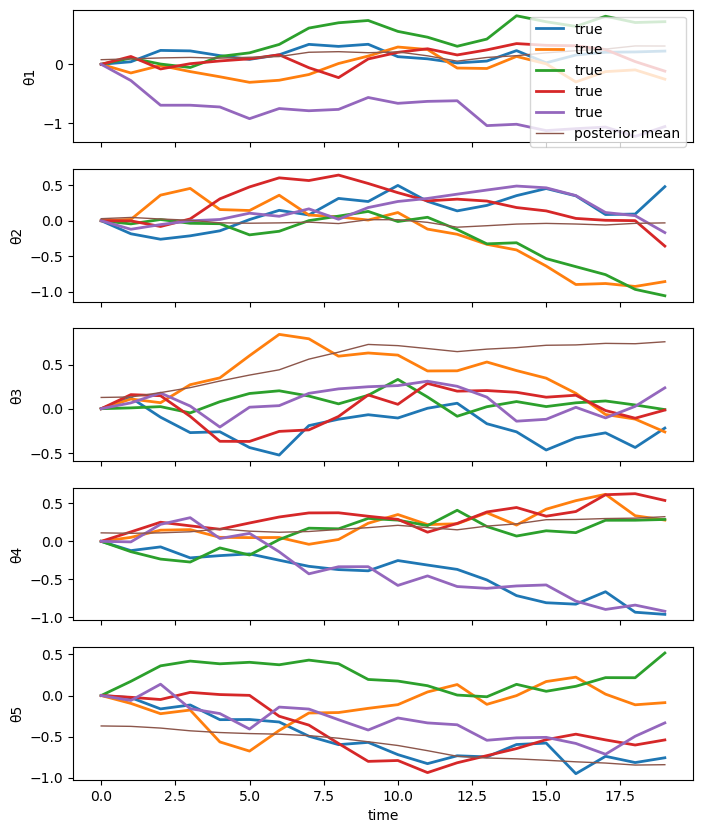

In [7]:
import matplotlib.pyplot as plt
print("theta_true:", theta_true.shape)   # should be (T, K)
print("theta_hat:", theta_hat.shape)     # should be (T, P, K)

# pick one grid cell (p=0) for comparison
p = 0

fig, ax = plt.subplots(K, 1, figsize=(8, 2*K), sharex=True)
for k in range(K):
    ax[k].plot(theta_true[:, k], lw=2, label="true")
    ax[k].plot(theta_hat[:, p, k], lw=1, label="posterior mean")
    ax[k].set_ylabel(f"θ{k+1}")
ax[0].legend()
ax[-1].set_xlabel("time")
plt.show()


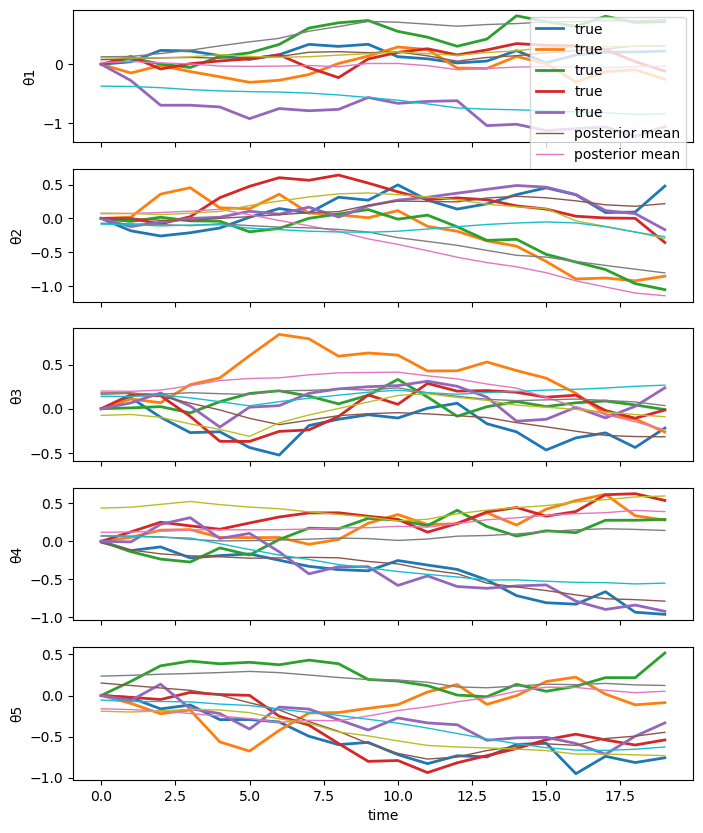

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(K, 1, figsize=(8, 2*K), sharex=True)
for k in range(K):
    ax[k].plot(theta_true[:,k], lw=2, label="true")
    ax[k].plot(theta_hat[:,k], lw=1, label="posterior mean")
    ax[k].set_ylabel(f"θ{k+1}")
ax[0].legend()
ax[-1].set_xlabel("time")
plt.show()


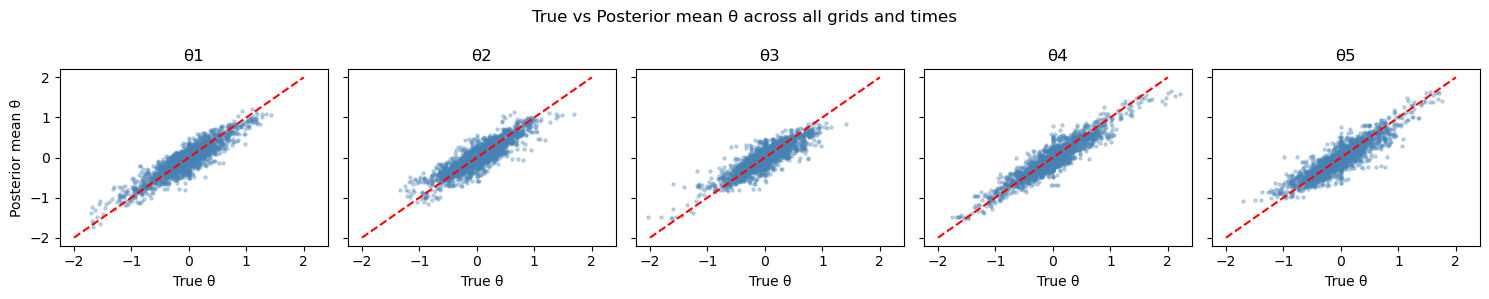

In [10]:
import matplotlib.pyplot as plt

# Flatten across time and grids for each channel k
theta_true_flat = theta_true.reshape(-1, K)          # (T*P, K)
theta_post_flat = theta_hat.reshape(-1, K)           # (T*P, K)

fig, ax = plt.subplots(1, K, figsize=(3*K, 3), sharex=True, sharey=True)

for k in range(K):
    ax[k].scatter(theta_true_flat[:, k], theta_post_flat[:, k],
                  alpha=0.3, s=5, color="steelblue")
    ax[k].plot([-2, 2], [-2, 2], "r--")  # 1:1 line (adjust range as needed)
    ax[k].set_title(f"θ{k+1}")
    ax[k].set_xlabel("True θ")
    if k == 0:
        ax[k].set_ylabel("Posterior mean θ")

plt.suptitle("True vs Posterior mean θ across all grids and times")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import r2_score
import numpy as np

for k in range(K):
    r2 = r2_score(theta_true_flat[:,k], theta_post_flat[:,k])
    corr = np.corrcoef(theta_true_flat[:,k], theta_post_flat[:,k])[0,1]
    print(f"θ{k+1}: R²={r2:.3f}, Corr={corr:.3f}")


θ1: R²=0.814, Corr=0.903
θ2: R²=0.771, Corr=0.879
θ3: R²=0.750, Corr=0.866
θ4: R²=0.862, Corr=0.929
θ5: R²=0.802, Corr=0.896


In [12]:
print("theta_true shape:", theta_true.shape)   # expected (T, P, K)
print("theta_hat shape:", theta_hat.shape)     # expected (T, P, K)

print("theta_true_flat shape:", theta_true_flat.shape)  # (T*P, K)
print("theta_post_flat shape:", theta_post_flat.shape)  # (T*P, K)

tt=8
print("Original [t=8]:", theta_true[tt, :5, :])   # first 5 grids at time 0

PP = theta_true.shape[1]
start = tt * PP
print(f"Flattened rows corresponding to t= {tt}, first 5 grids:\n", theta_true_flat[start:start+5, :])

theta_true shape: (20, 100, 5)
theta_hat shape: (20, 100, 5)
theta_true_flat shape: (2000, 5)
theta_post_flat shape: (2000, 5)
Original [t=8]: [[ 0.30400249  0.01331829  0.70516841 -0.22623841 -0.76582583]
 [ 0.31408935  0.05426825  0.06456929  0.64303084  0.02047529]
 [-0.11935725  0.59506902  0.05495544 -0.08801357  0.22470549]
 [-0.37106274  0.02443376  0.16457356  0.37512972 -0.33355608]
 [-0.59912794 -0.20765939  0.3874693  -0.58494697 -0.29531796]]
Flattened rows corresponding to t= 8, first 5 grids:
 [[ 0.30400249  0.01331829  0.70516841 -0.22623841 -0.76582583]
 [ 0.31408935  0.05426825  0.06456929  0.64303084  0.02047529]
 [-0.11935725  0.59506902  0.05495544 -0.08801357  0.22470549]
 [-0.37106274  0.02443376  0.16457356  0.37512972 -0.33355608]
 [-0.59912794 -0.20765939  0.3874693  -0.58494697 -0.29531796]]


Compute residuals

In [13]:
# Compute predictions
Y_pred = np.einsum("tpk, tpk -> tp", Z, theta_hat)   # (T,P)

# Residuals
residuals = Y - Y_pred   # (T,P)


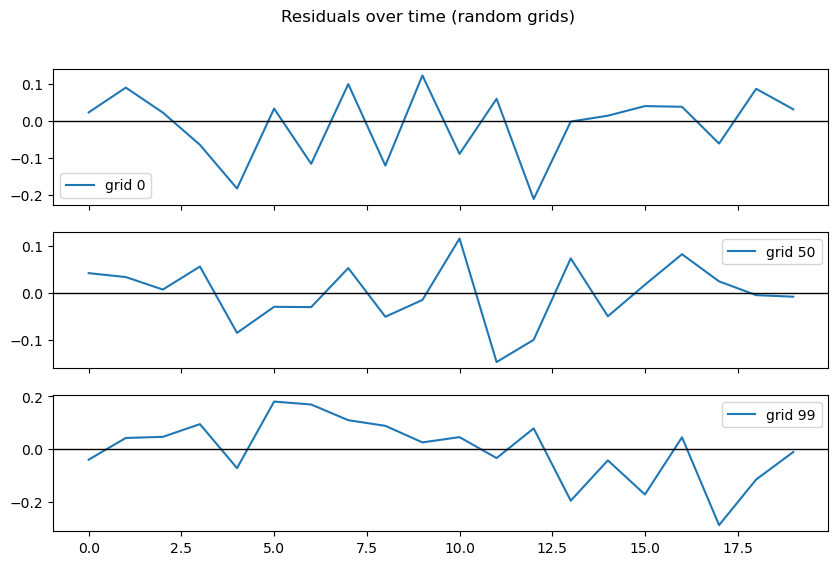

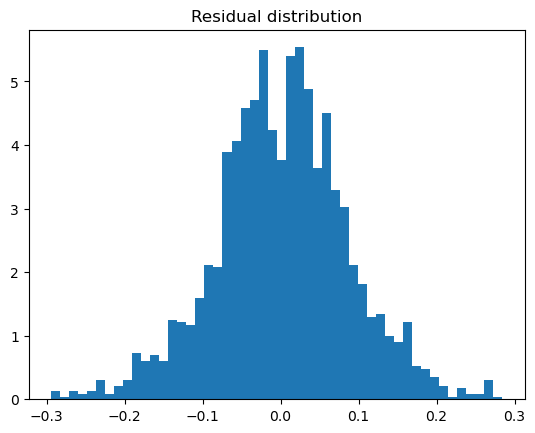

In [14]:
import matplotlib.pyplot as plt

# Plot residuals for a few random grid cells
fig, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
for i, p in enumerate([0, P//2, P-1]):   # first, middle, last grid
    ax[i].plot(residuals[:, p], label=f'grid {p}')
    ax[i].axhline(0, color="k", lw=1)
    ax[i].legend()
plt.suptitle("Residuals over time (random grids)")
plt.show()

# Histogram across all residuals
plt.hist(residuals.ravel(), bins=50, density=True)
plt.title("Residual distribution")
plt.show()


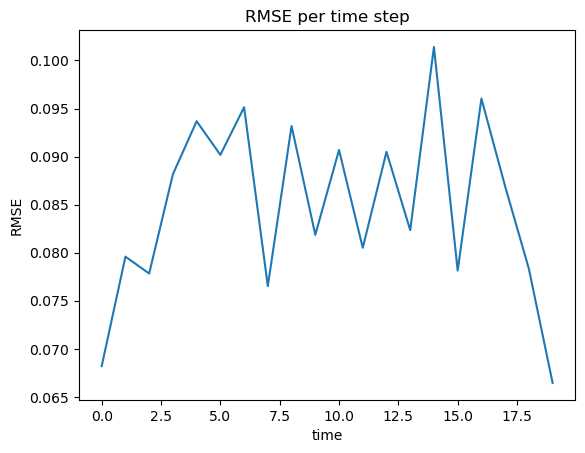

In [15]:
rmse_t = np.sqrt(np.mean(residuals**2, axis=1))   # (T,)
plt.plot(rmse_t)
plt.xlabel("time")
plt.ylabel("RMSE")
plt.title("RMSE per time step")
plt.show()


1) Convert cubes → (T,P) and (T,P,K) with a valid-pixel mask

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# --- assume already loaded ---
# insar = xr.open_dataset("insar_aligned.nc")
# w3ra  = xr.open_dataset("w3ra_on_insar.nc")


In [59]:
print(type(insar))
print(insar.dims)
print(list(insar.coords))
print(insar.data_vars)

print(type(w3ra))
print(w3ra.dims)
print(list(w3ra.coords))
print(w3ra.data_vars)


<class 'xarray.core.dataset.Dataset'>
FrozenMappingWarningOnValuesAccess({'y': 2939, 'x': 3713, 'time': 65})
['y', 'x', 'time', 'lat', 'lon']
Data variables:
    insar_deformation  (time, y, x) float32 3GB ...
<class 'xarray.core.dataset.Dataset'>
FrozenMappingWarningOnValuesAccess({'time': 65, 'y': 2939, 'x': 3713})
['time', 'lat', 'lon', 'y', 'x']
Data variables:
    S0       (time, y, x) float64 6GB ...
    Ss       (time, y, x) float64 6GB ...
    Sd       (time, y, x) float64 6GB ...
    Sg       (time, y, x) float64 6GB ...
    Sr       (time, y, x) float64 6GB ...


In [56]:
# Latitude/longitude arrays
lat_insar = insar['lat'].values
lon_insar = insar['lon'].values
lat_w3ra  = w3ra['lat'].values
lon_w3ra  = w3ra['lon'].values

# Extent
print("InSAR lat range:", lat_insar.min(), "to", lat_insar.max())
print("InSAR lon range:", lon_insar.min(), "to", lon_insar.max())
print("W3RA lat range:", lat_w3ra.min(), "to", lat_w3ra.max())
print("W3RA lon range:", lon_w3ra.min(), "to", lon_w3ra.max())

# Step size (assuming regular grid)
dlat_insar = float(lat_insar[1,0] - lat_insar[0,0])
dlon_insar = float(lon_insar[0,1] - lon_insar[0,0])
dlat_w3ra  = float(lat_w3ra[1,0] - lat_w3ra[0,0])
dlon_w3ra  = float(lon_w3ra[0,1] - lon_w3ra[0,0])

print("InSAR resolution (lat, lon):", dlat_insar, dlon_insar)
print("W3RA resolution (lat, lon):", dlat_w3ra, dlon_w3ra)



InSAR lat range: 43.704895 to 45.90842
InSAR lon range: 10.263688 to 14.117494
W3RA lat range: 43.704895 to 45.90842
W3RA lon range: 10.263688 to 14.117494
InSAR resolution (lat, lon): -0.0007171630859375 0.001026153564453125
W3RA resolution (lat, lon): -0.0007171630859375 0.001026153564453125


In [58]:
print("InSAR:", insar["insar_deformation"].shape)
print("W3RA", {v: w3ra[v].shape for v in w3ra})
factor = 10        # spatial: every 10th pixel
time_factor = 2    # temporal: every 2nd timestep

insar_coarse = insar.isel(y=slice(0, None, factor),
                          x=slice(0, None, factor),
                          time=slice(0, None, time_factor))

w3ra_coarse  = w3ra.isel(y=slice(0, None, factor),
                         x=slice(0, None, factor),
                         time=slice(0, None, time_factor))

print("InSAR coarse shape:", insar_coarse["insar_deformation"].shape)
print("W3RA coarse shapes:", {v: w3ra_coarse[v].shape for v in ["S0","Ss","Sd","Sg","Sr"]})


InSAR: (65, 2939, 3713)
W3RA {'S0': (65, 2939, 3713), 'Ss': (65, 2939, 3713), 'Sd': (65, 2939, 3713), 'Sg': (65, 2939, 3713), 'Sr': (65, 2939, 3713)}
InSAR coarse shape: (33, 294, 372)
W3RA coarse shapes: {'S0': (33, 294, 372), 'Ss': (33, 294, 372), 'Sd': (33, 294, 372), 'Sg': (33, 294, 372), 'Sr': (33, 294, 372)}


In [63]:
def subset_latlon_grid(ds, lat_min, lat_max, lon_min, lon_max):
    """
    Subset xarray dataset by lat/lon bounding box when lat/lon are 2D arrays.
    """
    lat2d = ds['lat'].values
    lon2d = ds['lon'].values
    
    mask = (lat2d >= lat_min) & (lat2d <= lat_max) & \
           (lon2d >= lon_min) & (lon2d <= lon_max)
    
    # get indices of box
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    
    return ds.isel(y=slice(y0, y1+1), x=slice(x0, x1+1))

# Example bounding box
lat_min, lat_max = 44.3, 44.7
lon_min, lon_max = 11.2, 11.7

insar_sub = subset_latlon_grid(insar_coarse, lat_min, lat_max, lon_min, lon_max)
w3ra_sub  = subset_latlon_grid(w3ra_coarse, lat_min, lat_max, lon_min, lon_max)

print("InSAR subset:", insar_sub["insar_deformation"].shape)
print("W3RA subset:", {v: w3ra_sub[v].shape for v in w3ra_sub})


InSAR subset: (33, 58, 52)
W3RA subset: {'S0': (33, 58, 52), 'Ss': (33, 58, 52), 'Sd': (33, 58, 52), 'Sg': (33, 58, 52), 'Sr': (33, 58, 52)}


In [64]:
# Latitude/longitude arrays
lat_insar_sub = insar_sub['lat'].values
lon_insar_sub = insar_sub['lon'].values
lat_w3ra_sub  = w3ra_sub['lat'].values
lon_w3ra_sub  = w3ra_sub['lon'].values

# Extent
print("InSAR suset lat range:", lat_insar_sub.min(), "to", lat_insar_sub.max())
print("InSAR subset lon range:", lon_insar_sub.min(), "to", lon_insar_sub.max())
print("W3RA subset lat range:", lat_w3ra_sub.min(), "to", lat_w3ra_sub.max())
print("W3RA subset lon range:", lon_w3ra_sub.min(), "to", lon_w3ra_sub.max())


# Step size (assuming regular grid)
dlat_insar_sub = float(lat_insar_sub[1,0] - lat_insar_sub[0,0])
dlon_insar_sub = float(lon_insar_sub[0,1] - lon_insar_sub[0,0])
dlat_w3ra_sub  = float(lat_w3ra_sub[1,0] - lat_w3ra_sub[0,0])
dlon_w3ra_sub  = float(lon_w3ra_sub[0,1] - lon_w3ra_sub[0,0])

print("InSAR subset resolution (lat, lon):", dlat_insar_sub, dlon_insar_sub)
print("W3RA subset resolution (lat, lon):", dlat_w3ra_sub, dlon_w3ra_sub)

InSAR suset lat range: 44.286488 to 44.712147
InSAR subset lon range: 11.183841 to 11.720951
W3RA subset lat range: 44.286488 to 44.712147
W3RA subset lon range: 11.183841 to 11.720951
InSAR subset resolution (lat, lon): -0.0071868896484375 0.010074615478515625
W3RA subset resolution (lat, lon): -0.0071868896484375 0.010074615478515625


In [ ]:

# 1. Subset area (adjust indices)
y0, y1 = 1000, 1200
x0, x1 = 1500, 1700

insar_sub = insar.isel(y=slice(y0,y1), x=slice(x0,x1))
w3ra_sub  = w3ra.isel(y=slice(y0,y1), x=slice(x0,x1))
print("InSAR subset:", insar_sub.shape)  # (time, 100, 100)
print("W3RA subset:", {v: w3ra_sub[v].shape for v in ["S0","Ss","Sd","Sg","Sr"]})


In [ ]:

# Compute anomalies for W3RA
w3ra_sub_anom = xr.Dataset({
    var: w3ra_sub[var] - w3ra_sub[var].mean("time")
    for var in ["S0","Ss","Sd","Sg","Sr"]
})

# Save both InSAR subset and W3RA anomalies
out_dir = BASE 
out_dir.mkdir(exist_ok=True)

insar_sub.to_netcdf(out_dir / "insar_sub.nc")
w3ra_sub_anom.to_netcdf(out_dir / "w3ra_sub_anom.nc")

print("Saved:")
print("  ", out_dir / "insar_sub.nc")
print("  ", out_dir / "w3ra_anom.nc")


/tmp/ipykernel_239849/4279627340.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ny, nx = insar_sub.dims["y"], insar_sub.dims["x"]


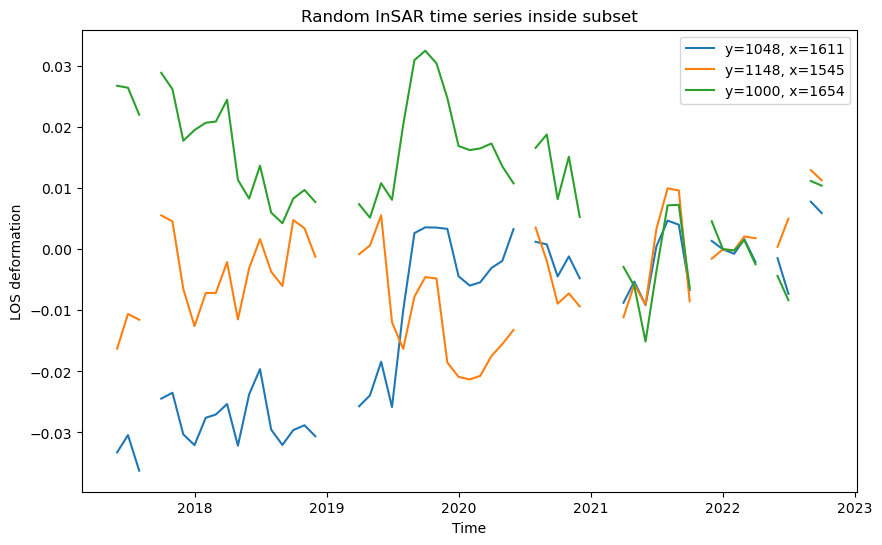

Subset lat range: 45.0053 to 45.1538
Subset lon range: 11.8457 to 12.0554


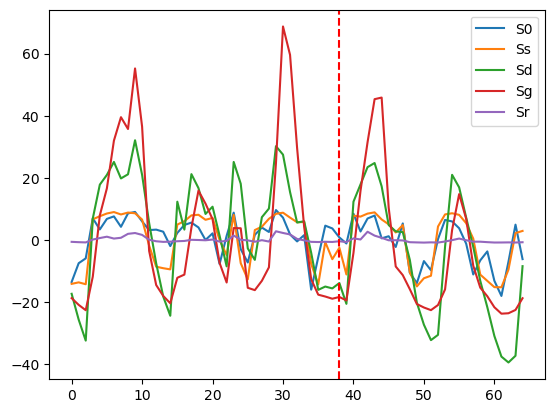

In [26]:

# Plot: InSAR time series for random points
ny, nx = insar_sub.dims["y"], insar_sub.dims["x"]
rand_points = [(np.random.randint(0,ny), np.random.randint(0,nx)) for _ in range(3)]

plt.figure(figsize=(10,6))
for (iy, ix) in rand_points:
    ts = insar_sub["insar_deformation"].isel(y=iy, x=ix)
    plt.plot(insar_sub["time"], ts, label=f"y={y0+iy}, x={x0+ix}")
plt.legend()
plt.xlabel("Time")
plt.ylabel("LOS deformation")
plt.title("Random InSAR time series inside subset")
plt.show()

# 4. Print lat/lon extent of subset
lat_min = float(insar_sub.lat.min())
lat_max = float(insar_sub.lat.max())
lon_min = float(insar_sub.lon.min())
lon_max = float(insar_sub.lon.max())

print(f"Subset lat range: {lat_min:.4f} to {lat_max:.4f}")
print(f"Subset lon range: {lon_min:.4f} to {lon_max:.4f}")

t_spike = 38
for var in ["S0","Ss","Sd","Sg","Sr"]:
    plt.plot(w3ra_sub_anom[var].mean(dim=("y","x")), label=var)
plt.axvline(t_spike, color="r", linestyle="--")
plt.legend(); plt.show()


In [35]:
import numpy as np
import xarray as xr

W3RA_VARS = ["S0","Ss","Sd","Sg","Sr"]   # adjust if needed
K = len(W3RA_VARS)

# shapes
T = insar_sub.sizes["time"]
H = insar_sub.sizes["y"]
W = insar_sub.sizes["x"]
P_tot = H*W

# --- build a "valid everywhere" mask ---
min_valid_frac = 0.4

# InSAR mask
mask = np.isfinite(insar_sub["insar_deformation"].values).mean(axis=0) > min_valid_frac

# W3RA anomalies mask (combine across variables)
for v in W3RA_VARS:
    mv = np.isfinite(w3ra_sub_anom[v].values).mean(axis=0) > min_valid_frac
    mask = mask & mv

print("Mask shape:", mask.shape, "valid fraction:", mask.mean())



# flatten indices of valid pixels
valid_ij = np.argwhere(mask)
P = valid_ij.shape[0]
print(f"T={T}, H={H}, W={W}, valid P={P} / {P_tot}")

# helper to extract (T,P) or (T,P,K)
def gather_tp(data_3d, valid_ij):
    # data_3d: (T,H,W) -> (T,P)
    out = np.empty((T, P), dtype=np.float32)
    for p,(i,j) in enumerate(valid_ij):
        out[:, p] = data_3d[:, i, j]
    return out

def gather_tpk(ds, varnames, valid_ij):
    # ds: xarray.Dataset with vars (T,H,W) -> (T,P,K)
    T = ds.sizes["time"]
    P = valid_ij.shape[0]
    K = len(varnames)
    Z = np.empty((T, P, K), dtype=np.float32)
    for k,v in enumerate(varnames):
        arr = ds[v].values  # (T,H,W)
        for p,(i,j) in enumerate(valid_ij):
            Z[:, p, k] = arr[:, i, j]
    return Z

# build Y and Z
Y_raw = gather_tp(insar_sub["insar_deformation"].values, valid_ij)     # (T,P)
Z_raw = gather_tpk(w3ra_sub_anom, W3RA_VARS, valid_ij) # (T,P,K)
print("Y_raw:", Y_raw.shape, "Z_raw:", Z_raw.shape)


Mask shape: (200, 200) valid fraction: 1.0
T=65, H=200, W=200, valid P=40000 / 40000
Y_raw: (65, 40000) Z_raw: (65, 40000, 5)


2) Light standardization (keep physics, just equalize scales)

Center per pixel over time for both Y and each Z channel.

Scale by per-pixel, per-channel std (with a small epsilon safeguard).

InSAR subset variables: ['insar_deformation']
InSAR subset coordinates: ['y', 'x', 'time', 'lat', 'lon']
W3RA anomaly variables: ['S0', 'Ss', 'Sd', 'Sg', 'Sr']
W3RA anomaly coordinates: ['time', 'lat', 'lon', 'y', 'x']


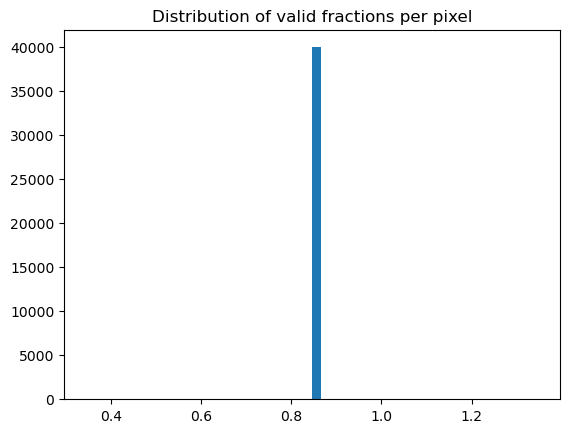

In [37]:
# List variables and coordinates in InSAR subset
print("InSAR subset variables:", list(insar_sub.data_vars))
print("InSAR subset coordinates:", list(insar_sub.coords))

# List variables and coordinates in W3RA anomalies
print("W3RA anomaly variables:", list(w3ra_sub_anom.data_vars))
print("W3RA anomaly coordinates:", list(w3ra_sub_anom.coords))

valid_frac = np.isfinite(insar_sub["insar_deformation"].values).mean(axis=0)
plt.hist(valid_frac.ravel(), bins=50)
plt.title("Distribution of valid fractions per pixel")
plt.show()


In [38]:
eps = 1e-6

# center & scale Y per pixel
Y_mean = np.nanmean(Y_raw, axis=0, keepdims=True)
Y_std  = np.nanstd (Y_raw, axis=0, keepdims=True) + eps
Y = (Y_raw - Y_mean) / Y_std

# center & scale Z per pixel, per channel
Z_mean = np.nanmean(Z_raw, axis=0, keepdims=True)   # (1,P,K)
Z_std  = np.nanstd (Z_raw, axis=0, keepdims=True) + eps
Z = (Z_raw - Z_mean) / Z_std

print("Standardized shapes -> Y:", Y.shape, "Z:", Z.shape)


Standardized shapes -> Y: (65, 40000) Z: (65, 40000, 5)


In [42]:
print("Std per channel in Z:", Z_raw.std(axis=(0,1)))


Std per channel in Z: [ 6.8450713  8.658787  19.421951  23.52924    0.926176 ]


3) Run the Gibbs+FFBS sampler on valid pixels

We’ll reuse your validated functions (ffbs_one_grid, iw_sample, update_Q_from_paths, update_R_from_residuals, gibbs_per_grid). Start with modest iterations; you can increase N later.

In [49]:
theta_hat, Q_hat, R_hat = gibbs_per_grid(
    Y, Z,
    N=400, burn=200,
    Q0=0.1*np.eye(K),   # <--- was 0.01
    nu0=K+5,            # <--- was K+2
    R0=0.1,             # noise prior
    m0=np.zeros(K),
    P0=1.0*np.eye(K),
    fix_R=False
)


print("theta_hat:", theta_hat.shape, "Q_hat:", Q_hat.shape, "R_hat:", R_hat)
# theta_hat is (T, P, K) only for valid pixels


/tmp/ipykernel_239849/3171103435.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(H @ Rf[t] @ H.T) + float(R)
/tmp/ipykernel_239849/3171103435.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  innov = y[t] - float(H @ a[t]) # scalar


[warn] nonfinite theta in grid 0, first bad at [0 0]
[warn] nonfinite theta in grid 1, first bad at [0 0]
[warn] nonfinite theta in grid 2, first bad at [0 0]
[warn] nonfinite theta in grid 3, first bad at [0 0]
[warn] nonfinite theta in grid 4, first bad at [0 0]
Δθ rms (grid 0): [0. 0. 0. 0. 0.]
[warn] nonfinite theta in grid 0, first bad at [0 0]
[warn] nonfinite theta in grid 1, first bad at [0 0]
[warn] nonfinite theta in grid 2, first bad at [0 0]
[warn] nonfinite theta in grid 3, first bad at [0 0]
[warn] nonfinite theta in grid 4, first bad at [0 0]
Δθ rms (grid 0): [0. 0. 0. 0. 0.]
[warn] nonfinite theta in grid 0, first bad at [0 0]
[warn] nonfinite theta in grid 1, first bad at [0 0]
[warn] nonfinite theta in grid 2, first bad at [0 0]
[warn] nonfinite theta in grid 3, first bad at [0 0]
[warn] nonfinite theta in grid 4, first bad at [0 0]
Δθ rms (grid 0): [0. 0. 0. 0. 0.]
[warn] nonfinite theta in grid 0, first bad at [0 0]
[warn] nonfinite theta in grid 1, first bad at [0 

In [51]:
BASE = Path("/mnt/data/mcma/01/")  # adjust to your folder


# Save as compressed .npz (keeps array structure)
np.savez_compressed(
    BASE / "bayes_output_results.npz",
    theta_hat=theta_hat,
    Q_hat=Q_hat,
    R_hat=R_hat
)


In [ ]:
# Loading later
import numpy as np
from pathlib import Path

BASE = Path("/mnt/data/mcma/01/")

# Load archive
data = np.load(BASE / "bayes_outputs.npz")

# Access arrays
theta_hat = data["theta_hat"]
Q_hat = data["Q_hat"]
R_hat = data["R_hat"]


In [52]:

print("theta_hat shape:", theta_hat.shape)
print("Q_hat shape:", Q_hat.shape)
print("R_hat:", R_hat)


theta_hat shape: (65, 40000, 5)
Q_hat shape: (5, 5)
R_hat: nan


In [53]:
# Shapes
print("theta_hat shape:", theta_hat.shape)   # (T, P, K)
print("Q_hat shape:", Q_hat.shape)           # (K, K)
print("R_hat:", R_hat, type(R_hat))          # scalar

# Statistics for theta_hat
print("\nTheta_hat stats:")
print("  mean:", np.nanmean(theta_hat))
print("  std:", np.nanstd(theta_hat))
print("  min:", np.nanmin(theta_hat))
print("  max:", np.nanmax(theta_hat))

# Norms per component (aggregate)
T, P, K = theta_hat.shape
for k in range(K):
    norm_k = np.linalg.norm(theta_hat[:, :, k])
    print(f"  ||theta_hat[:,:,{k}]||₂ =", norm_k)

# Q_hat stats
print("\nQ_hat matrix:")
print(Q_hat)
print("Eigenvalues of Q_hat:", np.linalg.eigvals(Q_hat))

# R_hat
print("\nR_hat value:", R_hat)


theta_hat shape: (65, 40000, 5)
Q_hat shape: (5, 5)
R_hat: nan <class 'numpy.float64'>

Theta_hat stats:
  mean: 0.0
  std: 0.0
  min: 0.0
  max: 0.0
  ||theta_hat[:,:,0]||₂ = nan
  ||theta_hat[:,:,1]||₂ = nan
  ||theta_hat[:,:,2]||₂ = nan
  ||theta_hat[:,:,3]||₂ = nan
  ||theta_hat[:,:,4]||₂ = nan

Q_hat matrix:
[[ 3.90612963e-08  1.39375046e-12  1.82906682e-13 -5.75692493e-13
   4.65724543e-13]
 [ 1.39375046e-12  3.90620589e-08  1.13020862e-12 -1.32902708e-12
   5.00410463e-13]
 [ 1.82906682e-13  1.13020862e-12  3.90626008e-08  1.92670904e-12
  -3.41682104e-12]
 [-5.75692493e-13 -1.32902708e-12  1.92670904e-12  3.90662470e-08
  -1.26105135e-12]
 [ 4.65724543e-13  5.00410463e-13 -3.41682104e-12 -1.26105135e-12
   3.90613262e-08]]
Eigenvalues of Q_hat: [3.90683161e-08 3.90645427e-08 3.90623735e-08 3.90601931e-08
 3.90581038e-08]

R_hat value: nan


4) Map θ back to (time,y,x,channel) for plotting/maps

In [ ]:
# container with NaNs for all pixels
theta_map = np.full((T, H, W, K), np.nan, dtype=np.float32)
for p,(i,j) in enumerate(valid_ij):
    theta_map[:, i, j, :] = theta_hat[:, p, :]

# also keep a small xarray wrapper for convenience
theta_da = xr.DataArray(
    theta_map,
    coords=dict(time=insar_sub.time, y=insar_sub.y, x=insar_sub.x, comp=np.arange(K)),
    dims=("time","y","x","comp"),
    name="theta"
)
theta_da.attrs["components"] = W3RA_VARS
theta_da


5) Quick diagnostics on real data

(a) Predicted vs observed maps at a chosen epoch

In [ ]:
# prediction in standardized units (match what the model saw)
Y_pred = np.einsum("tpk,tpk->tp", Z, theta_hat)  # (T,P)

# scatter back to (T,H,W) for a map at epoch t0
t0 = int(len(insar_sub.time)//2)

Yp_map = np.full((H,W), np.nan, dtype=np.float32)
Yr_map = np.full((H,W), np.nan, dtype=np.float32)

for p,(i,j) in enumerate(valid_ij):
    Yp_map[i,j] = Y_pred[t0, p]
    Yr_map[i,j] = Y[t0, p]

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3, figsize=(14,4))
im0=ax[0].imshow(Yr_map, cmap="RdBu", vmin=-2, vmax=2); ax[0].set_title("Observed (std units)")
im1=ax[1].imshow(Yp_map, cmap="RdBu", vmin=-2, vmax=2); ax[1].set_title("Predicted (std units)")
im2=ax[2].imshow(Yr_map-Yp_map, cmap="RdBu", vmin=-2, vmax=2); ax[2].set_title("Residual")
for a in ax: a.axis("off")
plt.colorbar(im2, ax=ax.ravel().tolist(), shrink=0.6)
plt.show()


(b) RMSE map (averaged over time)

In [ ]:
residuals = np.full((T,P), np.nan, dtype=np.float32)
residuals = Y - Y_pred
rmse_p = np.sqrt(np.nanmean(residuals**2, axis=0))  # (P,)

rmse_map = np.full((H,W), np.nan, dtype=np.float32)
for p,(i,j) in enumerate(valid_ij):
    rmse_map[i,j] = rmse_p[p]

plt.figure(figsize=(5,4))
plt.imshow(rmse_map, cmap="viridis")
plt.title("RMSE per pixel (std units)")
plt.axis("off"); plt.colorbar(shrink=0.7); plt.show()


(c) Linear trend maps of selected θ component (like Mehrnegar)

In [ ]:
def linear_slope_over_time(arr_T):
    # arr_T: (T,) -> slope of best-fit line vs time index
    t = np.arange(arr_T.shape[0])
    # np.polyfit returns (slope, intercept)
    return np.polyfit(t, arr_T, 1)[0]

# Example for groundwater-related component "Sg"
k_sg = W3RA_VARS.index("Sg")

sg_trend = np.full((H,W), np.nan, dtype=np.float32)
for p,(i,j) in enumerate(valid_ij):
    sg_trend[i,j] = linear_slope_over_time(theta_hat[:, p, k_sg])

plt.figure(figsize=(5,4))
plt.imshow(sg_trend, cmap="RdBu")
plt.title("Linear trend of θ(Sg) (per month, std units)")
plt.axis("off"); plt.colorbar(shrink=0.7); plt.show()


(d) Time-series at a point

In [ ]:
# pick a point near map center that is valid
py, px = valid_ij[len(valid_ij)//2]
pidx = np.where((valid_ij[:,0]==py) & (valid_ij[:,1]==px))[0][0]

plt.figure(figsize=(8,4))
plt.plot(Y[:, pidx], label="Y (std)")
plt.plot(Y_pred[:, pidx], label="Y_pred (std)")
plt.legend(); plt.title(f"Pixel (y={py}, x={px})"); plt.xlabel("time"); plt.show()

# θ components at this pixel
fig, ax = plt.subplots(K,1, figsize=(7, 2.2*K), sharex=True)
for k,v in enumerate(W3RA_VARS):
    ax[k].plot(theta_hat[:, pidx, k])
    ax[k].set_ylabel(v)
ax[-1].set_xlabel("time")
fig.suptitle("Posterior mean θ at one pixel")
plt.show()


1) Extract a subset from the big grids

In [17]:
# pick a manageable window
y0, y1 = 1000, 1200
x0, x1 = 1500, 1700

insar_sub = insar["insar_deformation"].isel(y=slice(y0,y1), x=slice(x0,x1))
w3ra_sub  = w3ra.isel(y=slice(y0,y1), x=slice(x0,x1))

print("InSAR subset:", insar_sub.shape)  # (time, 100, 100)
print("W3RA subset:", {v: w3ra_sub[v].shape for v in ["S0","Ss","Sd","Sg","Sr"]})


InSAR subset: (65, 200, 200)
W3RA subset: {'S0': (65, 200, 200), 'Ss': (65, 200, 200), 'Sd': (65, 200, 200), 'Sg': (65, 200, 200), 'Sr': (65, 200, 200)}


2) Flatten per epoch into Y_t and Z_t

In [44]:
def flatten_epoch(t, insar_da, w3ra_ds):
    """
    Extract and flatten InSAR and W3RA for epoch t.
    insar_da: DataArray (time, y, x)
    w3ra_ds:  Dataset with 5 vars (time, y, x)
    Returns:
      Y_t: (P,)
      Z_t: (P, 5)
    """
    # InSAR
    Y_t = insar_da.isel(time=t).values.ravel()

    # W3RA stacked
    Z_t = np.stack([
        w3ra_ds["S0"].isel(time=t).values.ravel(),
        w3ra_ds["Ss"].isel(time=t).values.ravel(),
        w3ra_ds["Sd"].isel(time=t).values.ravel(),
        w3ra_ds["Sg"].isel(time=t).values.ravel(),
        w3ra_ds["Sr"].isel(time=t).values.ravel()
    ], axis=-1)

    return Y_t, Z_t

# Example: first epoch
Y_t, Z_t = flatten_epoch(0, insar_sub, w3ra_sub)
print("Y_t:", Y_t.shape, "Z_t:", Z_t.shape)


Y_t: (10000,) Z_t: (10000, 5)


3) Build full Y, Z arrays for the sampler

In [45]:
T = insar_sub.sizes["time"]
P = insar_sub.sizes["y"] * insar_sub.sizes["x"]

Y = np.zeros((T, P), dtype=np.float32)
Z = np.zeros((T, P, 5), dtype=np.float32)

for t in range(T):
    Y[t], Z[t] = flatten_epoch(t, insar_sub, w3ra_sub)

print("Final Y:", Y.shape, "Z:", Z.shape)


Final Y: (65, 10000) Z: (65, 10000, 5)


In [46]:
eps = 1e-3  # threshold for variance

Y = np.zeros((T, P), dtype=np.float32)
Z = np.zeros((T, P, 5), dtype=np.float32)

valid_mask = np.ones((T, 5), dtype=bool)  # track which vars are kept per epoch

for t in range(T):
    Y_t, Z_t = flatten_epoch(t, insar_sub, w3ra_sub)

    # check variance per predictor
    stds = np.nanstd(Z_t, axis=0)
    keep = stds > eps
    valid_mask[t] = keep

    # keep only predictors that are not flat
    Z_t[:, ~keep] = 0.0   # force flat columns to 0 → sampler won’t blow up

    Y[t] = Y_t
    Z[t] = Z_t


In [47]:
# Replace NaNs with 0 (or better: mask them)
Y = np.nan_to_num(Y, nan=0.0)
Z = np.nan_to_num(Z, nan=0.0)


In [48]:
def standardize_epoch(Y_t, Z_t, eps=1e-6):
    # center & scale Y
    y = Y_t.copy()
    y_mean = np.nanmean(y); y_std = np.nanstd(y) + eps
    y = (y - y_mean) / y_std

    # center & scale each Z column
    Zs = Z_t.copy()
    means = np.nanmean(Zs, axis=0)
    stds  = np.nanstd(Zs, axis=0) + eps
    Zs = (Zs - means) / stds
    return y, Zs

Y_std = np.zeros_like(Y)
Z_std = np.zeros_like(Z)
for t in range(T):
    Y_std[t], Z_std[t] = standardize_epoch(Y[t], Z[t])

# re-run Gibbs with Y_std, Z_std
theta_path, _, _ = ffbs_linear_gaussian(Y_std, Z_std, Q, sigma_eps2)


In [49]:
# Hyperparams
N = 300         # total iterations (start small, e.g. 300, can increase later)
B = 100         # burn-in
sigma_eps2 = 0.05**2    # observation noise variance (tune as needed)
Q = 0.01*np.eye(5)       # initial Q
Q0 = 0.01*np.eye(5)     # IW prior scale
nu0 = 5 + 5             # IW prior dof

samples = []
for it in range(N):
    # Step A: sample theta path given Q
    theta_path, _, _ = ffbs_linear_gaussian(Y, Z, Q, sigma_eps2)

    # Step B: sample Q given theta path
    Q = update_Q_from_path(theta_path, Q0, nu0)

    if it >= B:
        samples.append((theta_path.copy(), Q.copy()))
    if (it+1) % 50 == 0:
        print(f"iter {it+1}/{N}")

# Posterior means
theta_hat = np.mean([s[0] for s in samples], axis=0)   # (T,5)
Q_hat     = np.mean([s[1] for s in samples], axis=0)

print("theta_hat:", theta_hat.shape)
print("Q_hat:\n", Q_hat)


/tmp/ipykernel_168809/4094338907.py:63: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  theta[t] = rng.multivariate_normal(mean_s, cov_s)


iter 50/300
iter 100/300
iter 150/300
iter 200/300
iter 250/300
iter 300/300
theta_hat: (65, 5)
Q_hat:
 [[ 6.60196177e-01 -2.13321347e-02 -4.50203168e-02  1.20466930e-01
  -3.43521381e+00]
 [-2.13321347e-02  1.63232283e-01 -1.88710176e-02  2.91683576e-02
  -6.64662492e-01]
 [-4.50203168e-02 -1.88710176e-02  1.20971316e-02 -6.59736633e-03
   7.32629905e-02]
 [ 1.20466930e-01  2.91683576e-02 -6.59736633e-03  8.72509959e-02
  -1.89958856e+00]
 [-3.43521381e+00 -6.64662492e-01  7.32629905e-02 -1.89958856e+00
   5.06214388e+01]]


3) Quick plot of inferred weights

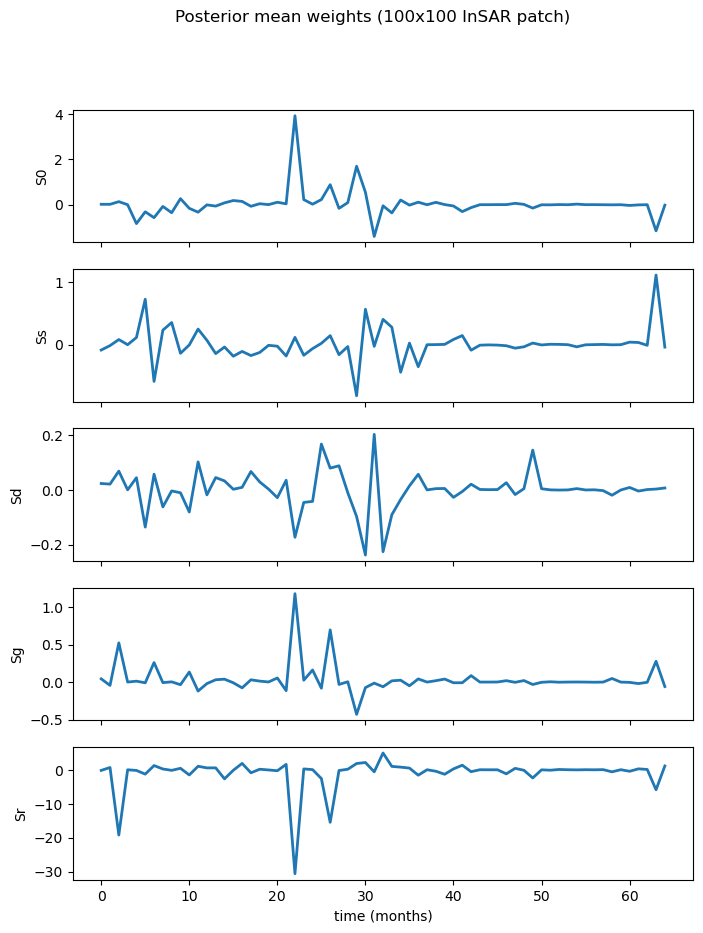

In [50]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 1, figsize=(8, 10), sharex=True)
for k, var in enumerate(["S0","Ss","Sd","Sg","Sr"]):
    ax[k].plot(theta_hat[:,k], lw=2)
    ax[k].set_ylabel(var)
ax[-1].set_xlabel("time (months)")
plt.suptitle("Posterior mean weights (100x100 InSAR patch)")
plt.show()


In [51]:
k = 4  # Sr index
t_spike = int(np.nanargmax(np.abs(theta_hat[:,k])))
print("Spike at t =", t_spike, "time =", np.array(insar_sub.time.values)[t_spike])

def describe_epoch(t):
    zs = Z[t]  # (P,5)
    print("epoch", t, "Y std:", np.nanstd(Y[t]))
    for j, name in enumerate(["S0","Ss","Sd","Sg","Sr"]):
        print(name, "std:", np.nanstd(zs[:,j]), "min/max:", np.nanmin(zs[:,j]), np.nanmax(zs[:,j]))
describe_epoch(t_spike)


Spike at t = 22 time = 2019-04-01T00:00:00.000000000
epoch 22 Y std: 0.035843138
S0 std: 0.09326582 min/max: 1.4234768 1.8105943
Ss std: 0.31629896 min/max: -3.914491 -2.7381713
Sd std: 0.29895157 min/max: -10.007299 -8.566785
Sg std: 0.3706896 min/max: -16.551144 -14.798793
Sr std: 0.013097208 min/max: -0.39724284 -0.33851355


RMSE per month (std-units): [9.45230563e-01 1.32594763e+00 1.84983516e+01 1.28580849e-02
 1.11489153e+00 2.20213371e+00 1.78305750e+00 1.10611333e+00
 9.52612634e-01 1.20654669e+00 1.51630475e+00 1.29880285e+00
 9.72428725e-01 1.08315681e+00 2.89491625e+00 1.00475151e+00
 1.87116813e+00 1.39359220e+00 9.50244012e-01 6.72039692e-02
 1.09753315e+00 1.34564303e+00 2.83854893e+01 1.05219087e+00
 9.91710721e-01 2.30949594e+00 1.39007127e+01 1.07626051e+00
 9.59201070e-01 9.96616550e-01 1.90680538e+00 1.44612359e+00
 5.38653047e+00 1.20827252e+00 1.26077328e+00 1.20866305e+00
 1.54671724e+00 1.05760920e-03 9.88260841e-01 1.37688186e+00
 1.00357517e+00 1.33463041e+00 1.11692704e+00 3.41287815e-03
 1.71787918e-02 1.85073565e-02 1.30891032e+00 9.69694802e-01
 9.71801614e-01 2.83422129e+00 1.00903031e+00 1.02906694e+00
 9.64088565e-01 3.08822225e-03 1.00668340e+00 6.25521834e-03
 9.96954866e-01 1.00307578e+00 9.60211058e-01 1.06177420e-02
 9.99159493e-01 1.06914866e+00 7.19715090e-02 5.29470536e

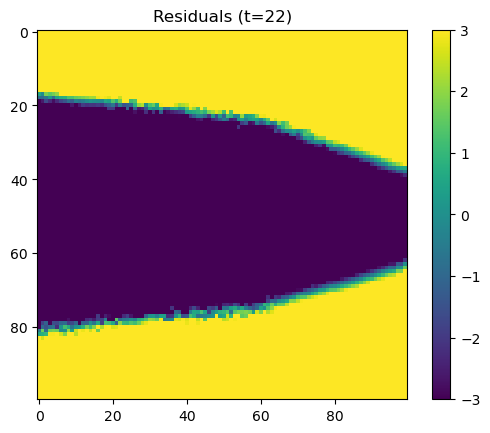

In [52]:
# posterior mean path after re-run -> theta_hat_std (T,5)
Y_pred = np.einsum('tpk,tk->tp', Z_std, theta_hat)  # (T,P)
resid  = Y_std - Y_pred

rmse_t = np.sqrt(np.nanmean(resid**2, axis=1))
print("RMSE per month (std-units):", rmse_t)

# quick map for spike epoch residuals
t = t_spike
res_map = resid[t].reshape(insar_sub.sizes['y'], insar_sub.sizes['x'])
plt.imshow(res_map, vmin=-3, vmax=3); plt.colorbar(); plt.title(f"Residuals (t={t})"); plt.show()


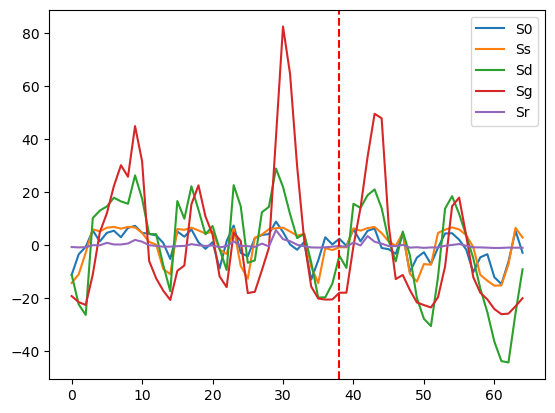

In [53]:
t_spike = 38
for var in ["S0","Ss","Sd","Sg","Sr"]:
    plt.plot(w3ra_sub[var].mean(dim=("y","x")), label=var)
plt.axvline(t_spike, color="r", linestyle="--")
plt.legend(); plt.show()


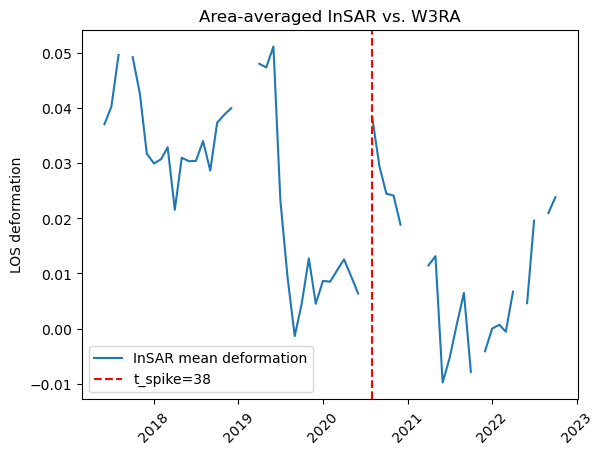

In [56]:
# InSAR area average over patch
insar_ts_mean = insar_sub.mean(dim=("y","x")).values
time_vals = insar_sub.time.values

plt.plot(time_vals, insar_ts_mean, label="InSAR mean deformation")
plt.axvline(time_vals[t_spike], color="r", linestyle="--", label=f"t_spike={t_spike}")
plt.xticks(rotation=45)
plt.ylabel("LOS deformation")
plt.legend()
plt.title("Area-averaged InSAR vs. W3RA")
plt.show()


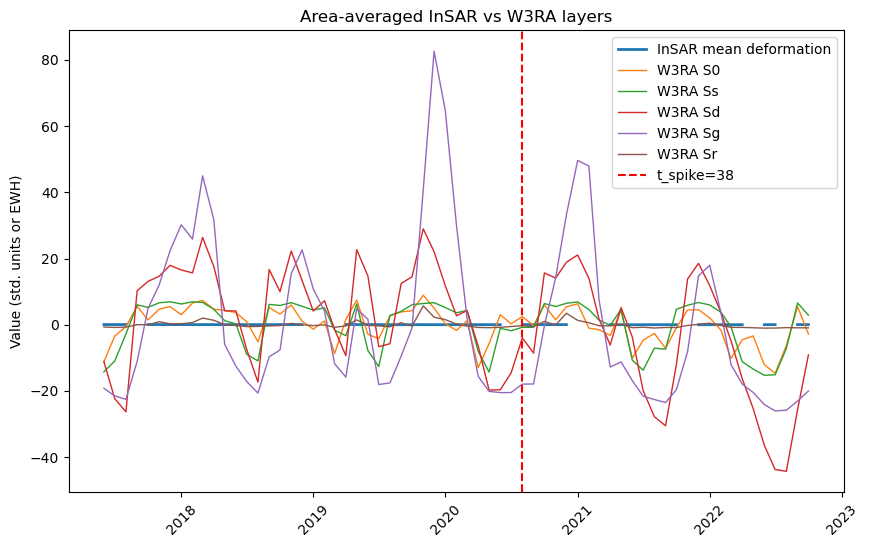

In [57]:
# InSAR mean deformation
insar_ts_mean = insar_sub.mean(dim=("y","x")).values
time_vals = insar_sub.time.values

plt.figure(figsize=(10,6))

# Plot InSAR
plt.plot(time_vals, insar_ts_mean, label="InSAR mean deformation", lw=2)

# Plot W3RA mean for each variable
for var in ["S0","Ss","Sd","Sg","Sr"]:
    plt.plot(w3ra_sub.time.values, 
             w3ra_sub[var].mean(dim=("y","x")).values, 
             label=f"W3RA {var}", lw=1)

# Mark the spike
plt.axvline(time_vals[t_spike], color="r", linestyle="--", label=f"t_spike={t_spike}")

plt.xticks(rotation=45)
plt.ylabel("Value (std. units or EWH)")
plt.title("Area-averaged InSAR vs W3RA layers")
plt.legend()
plt.show()


In [61]:
print("theta_hat:", theta_hat.shape)
print("Z_std:", Z_std.shape)


theta_hat: (65, 5)
Z_std: (65, 10000, 5)


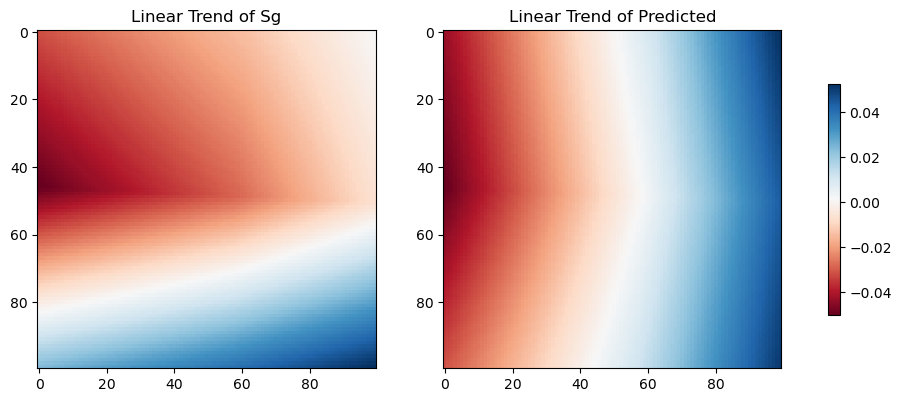

In [62]:
# Example: groundwater (Sg)
sg = w3ra_sub["Sg"].values   # (T, y, x)

# Predicted from model: (T, P)
pred_all = np.einsum("tk,tpk->tp", theta_hat, Z_std)   # (65, 10000)


# Reshape back to grid
pred_all = pred_all.reshape(insar_sub.sizes['time'],
                            insar_sub.sizes['y'],
                            insar_sub.sizes['x'])     # (T, y, x)

# Function to compute linear slope along time
def linear_trend(arr, time):
    x = np.arange(len(time))
    slope, _ = np.polyfit(x, arr, 1)
    return slope

time = np.arange(insar_sub.sizes['time'])

# Apply along each grid cell
sg = w3ra_sub["Sg"].values  # (T, y, x)
sg_trend = np.apply_along_axis(linear_trend, 0, sg, time)        # (y, x)
pred_trend = np.apply_along_axis(linear_trend, 0, pred_all, time)  # (y, x)

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(sg_trend, cmap="RdBu"); ax[0].set_title("Linear Trend of Sg")
im1 = ax[1].imshow(pred_trend, cmap="RdBu"); ax[1].set_title("Linear Trend of Predicted")
plt.colorbar(im1, ax=ax.ravel().tolist(), shrink=0.6)
plt.show()



In [39]:
print("InSAR array shape:", insar_sub.sizes)  # gives (time, y, x)
print("Lat shape:", insar_sub.lat.shape)
print("Lon shape:", insar_sub.lon.shape)


InSAR array shape: Frozen({'time': 65, 'y': 100, 'x': 100})
Lat shape: (100, 100)
Lon shape: (100, 100)


In [40]:
lat_patch = insar_sub.lat.values
lon_patch = insar_sub.lon.values

print("Patch lat range:", float(lat_patch.min()), float(lat_patch.max()))
print("Patch lon range:", float(lon_patch.min()), float(lon_patch.max()))


Patch lat range: 45.062103271484375 45.136436462402344
Patch lon range: 11.337886810302734 11.442838668823242


In [43]:
import h5py, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
'''
USAGE: 
train_ds = InSAR2W3RA(INSAR_H5, W3RA_H5, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="train")
val_ds   = InSAR2W3RA(INSAR_H5, W3RA_H5, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="val")

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(val_ds)
'''

class InSAR2W3RA(Dataset):
    def __init__(self, insar_h5, w3ra_h5, win_t=12, patch_sz=(1,128,128), stride=(1,128,128),
                 split="train", val_frac=0.1, test_frac=0.1, zscore=True, seed=0):
        self.f_in = h5py.File(insar_h5, "r")
        self.f_w3 = h5py.File(w3ra_h5,  "r")
        self.D_in = self.f_in["InSAR"]        # (T,H,W)
        self.D0 = self.f_w3["S0"]             # (T,H,W)
        self.Dd = self.f_w3["Sd"]
        self.Dg = self.f_w3["Sg"]

        T,H,W = self.D_in.shape
        self.win_t = win_t
        self.pz = patch_sz
        self.stride = stride
        assert patch_sz[0] in (1, win_t), "Time patch must be 1 or WIN_T; use WIN_T here."
        assert win_t <= T

        # build list of (t0,y0,x0) windows
        t_idx = np.arange(0, T - win_t + 1, stride[0])
        y_idx = np.arange(0, H - patch_sz[1] + 1, stride[1])
        x_idx = np.arange(0, W - patch_sz[2] + 1, stride[2])
        idx = np.stack(np.meshgrid(t_idx, y_idx, x_idx, indexing="ij"), -1).reshape(-1,3)

        # split by time (keeps spatial leakage low)
        n_t = len(t_idx)
        n_val = max(1,int(n_t*val_frac))
        n_test= max(1,int(n_t*test_frac))
        rng = np.random.default_rng(seed)
        # choose complete time starts for val/test
        t_perm = rng.permutation(n_t)
        t_val  = set(t_idx[t_perm[:n_val]])
        t_test = set(t_idx[t_perm[n_val:n_val+n_test]])

        if split=="train":
            mask = np.array([t not in t_val and t not in t_test for t,_,_ in idx])
        elif split=="val":
            mask = np.array([t in t_val for t,_,_ in idx])
        else:
            mask = np.array([t in t_test for t,_,_ in idx])

        self.samples = idx[mask]

        # compute z-score statistics (approx: sample 200 patches)
        self.zscore = zscore
        if zscore:
            self.x_mean, self.x_std, self.y_mean, self.y_std = self._estimate_stats(rng, nsamp=200)
        else:
            self.x_mean = self.x_std = self.y_mean = self.y_std = None

    def _estimate_stats(self, rng, nsamp=200):
        xs, ys = [], []
        for _ in range(min(nsamp, len(self.samples))):
            t,y,x = self.samples[rng.integers(len(self.samples))]
            s = slice(t, t+self.win_t)
            yy = slice(y, y+self.pz[1]); xx = slice(x, x+self.pz[2])
            xin = self.D_in[s, yy, xx]       # (T,H,W)
            yout = np.stack([self.D0[s, yy, xx],
                             self.Dd[s, yy, xx],
                             self.Dg[s, yy, xx]], axis=0)   # (3,T,H,W)
            xs.append(np.nan_to_num(xin, nan=0.0))
            ys.append(np.nan_to_num(yout, nan=0.0))
        xcat = np.concatenate([u.reshape(-1,1) for u in xs],0)
        ycat = np.concatenate([u.reshape(-1,1) for u in ys],0)
        x_mean, x_std = float(np.mean(xcat)), float(np.std(xcat)+1e-6)
        y_mean, y_std = float(np.mean(ycat)), float(np.std(ycat)+1e-6)
        return x_mean, x_std, y_mean, y_std

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        t,y,x = self.samples[i]
        s = slice(t, t+self.win_t)
        yy = slice(y, y+self.pz[1]); xx = slice(x, x+self.pz[2])

        xin  = self.D_in[s, yy, xx].astype(np.float32)         # (T,H,W)
        yout = np.stack([ self.D0[s,yy,xx], self.Dd[s,yy,xx], self.Dg[s,yy,xx] ],
                        axis=0).astype(np.float32)             # (3,T,H,W)

        # masks for NaN
        m = ~np.isnan(yout)                                    # (3,T,H,W)
        xin  = np.nan_to_num(xin,  nan=0.0)
        yout = np.nan_to_num(yout, nan=0.0)

        if self.zscore:
            xin  = (xin  - self.x_mean)/self.x_std
            yout = (yout - self.y_mean)/self.y_std

        x_t = torch.from_numpy(xin).unsqueeze(0)               # [1,T,H,W]
        y_t = torch.from_numpy(yout)                           # [3,T,H,W]
        m_t = torch.from_numpy(m.astype(np.float32))           # [3,T,H,W]
        return x_t, y_t, m_t


In [48]:
import xarray as xr
from pathlib import Path


p = BASE / "w3ra_aligned.nc"
try:
    ds = xr.open_dataset(p)
    print("\n---", name, "---")
    print("vars:", list(ds.data_vars)[:10])
    print("dims:", dict(ds.dims))
    if "time" in ds:
        print("time:", str(ds.time.values[:3]), "…", str(ds.time.values[-3:]), f"({ds.dims['time']} steps)")
    ds.close()
except Exception as e:
    print("\n---", name, "---\n", e)



--- S0 ---
vars: ['Sg', 'Sd', 'S0']
dims: {'lat': 22, 'lon': 24, 'time': 65}
time: ['2017-06-01T00:00:00.000000000' '2017-07-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000'] … ['2022-08-01T00:00:00.000000000' '2022-09-01T00:00:00.000000000'
 '2022-10-01T00:00:00.000000000'] (65 steps)


C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2079874011.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("dims:", dict(ds.dims))
C:\Users\JR80FD\AppData\Local\Temp\ipykernel_16316\2079874011.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("time:", str(ds.time.values[:3]), "…", str(ds.time.values[-3:]), f"({ds.dims['time']} steps)")


In [44]:
from torch.utils.data import DataLoader


train_ds = InSAR2W3RA(INSAR_H5_ts, W3RA_H5_ts, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="train")
val_ds   = InSAR2W3RA(INSAR_H5_ts, W3RA_H5_ts, win_t=WIN_T, patch_sz=PATCH, stride=STRIDE, split="val")


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=True, num_workers=0,  # <-- important
                      pin_memory=False, persistent_workers=False)

val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE,
                      shuffle=False, num_workers=0, # <-- important
                      pin_memory=False, persistent_workers=False)



len(train_ds), len(val_ds)

KeyError: "Unable to synchronously open object (object 'S0' doesn't exist)"

In [46]:
import torch.nn as nn
import torch.nn.functional as F

def window_partition_3d(x, win):  # x: [B,T,H,W,C]
    WT,WH,WW = win
    B,T,H,W,C = x.shape
    assert T%WT==0 and H%WH==0 and W%WW==0
    x = x.view(B, T//WT, WT, H//WH, WH, W//WW, WW, C)
    x = x.permute(0,1,3,5,2,4,6,7).contiguous()               # [B, nWT, nWH, nWW, WT, WH, WW, C]
    return x.view(-1, WT*WH*WW, C)                            # [B*nWins, tokens, C]

def window_unpartition_3d(windows, win, B, T, H, W, C):
    WT,WH,WW = win
    nWT, nWH, nWW = T//WT, H//WH, W//WW
    x = windows.view(B, nWT, nWH, nWW, WT, WH, WW, C)
    x = x.permute(0,1,4,2,5,3,6,7).contiguous()
    return x.view(B, T, H, W, C)

class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim*mlp_ratio)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(dim*mlp_ratio, dim)
    def forward(self, x): return self.fc2(self.act(self.fc1(x)))

class SwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=(2,4,4), shift=False):
        super().__init__()
        self.dim = dim
        self.win = window_size
        self.shift = shift
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim)

    def forward(self, x):               # x: [B,T,H,W,C]
        B,T,H,W,C = x.shape
        if self.shift:
            sT,sH,sW = self.win[0]//2, self.win[1]//2, self.win[2]//2
            x = torch.roll(x, shifts=(-sT,-sH,-sW), dims=(1,2,3))
        # partition → attn per window
        xw = window_partition_3d(x, self.win)               # [B*nWins, tokens, C]
        xw = self.norm1(xw)
        attn_out,_ = self.attn(xw, xw, xw)                  # window MSA
        xw = xw + attn_out
        xw = xw + self.mlp(self.norm2(xw))
        # unpartition
        x = window_unpartition_3d(xw, self.win, B,T,H,W,C)
        if self.shift:
            sT,sH,sW = self.win[0]//2, self.win[1]//2, self.win[2]//2
            x = torch.roll(x, shifts=(+sT,+sH,+sW), dims=(1,2,3))
        return x

class PatchEmbed3D(nn.Module):
    def __init__(self, in_ch=1, embed_dim=96, patch_size=(1,4,4)):
        super().__init__()
        self.proj = nn.Conv3d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):               # [B,1,T,H,W]
        x = self.proj(x)                # [B,C,T',H',W']
        x = x.permute(0,2,3,4,1)        # → [B,T',H',W',C]
        return x

class PatchMerge3D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.reduction = nn.Linear(dim*4, dim*2)
    def forward(self, x):               # [B,T,H,W,C]
        B,T,H,W,C = x.shape
        x = x.view(B,T, H//2,2, W//2,2, C).permute(0,1,2,4,3,5,6).contiguous()
        x = x.view(B,T, H//2, W//2, 4*C)
        return self.reduction(x)

class PatchExpand3D(nn.Module):
    def __init__(self, dim_out):
        super().__init__()
        self.dim_out = dim_out
    def forward(self, x):               # [B,T,H,W,Cin] → upsample H,W x2, reduce channels
        B,T,H,W,C = x.shape
        x = x.permute(0,4,1,2,3)        # [B,C,T,H,W]
        x = F.interpolate(x, scale_factor=(1,2,2), mode="trilinear", align_corners=False)
        x = nn.Conv3d(C, self.dim_out, kernel_size=1)(x)
        return x.permute(0,2,3,4,1)     # [B,T,H',W',Cout]

class SwinUNet3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, embed_dim=96,
                 depths=(2,2,2), num_heads=(3,3,3),
                 window_size=(2,4,4), patch_size=(1,4,4)):
        super().__init__()
        self.patch_embed = PatchEmbed3D(in_ch, embed_dim, patch_size)
        C = embed_dim

        # encoder stages
        self.enc1 = nn.ModuleList([SwinBlock3D(C,   num_heads[0], window_size, shift=(i%2==1)) for i in range(depths[0])])
        self.pm1  = PatchMerge3D(C);   C *= 2
        self.enc2 = nn.ModuleList([SwinBlock3D(C,   num_heads[1], window_size, shift=(i%2==1)) for i in range(depths[1])])
        self.pm2  = PatchMerge3D(C);   C *= 2
        self.enc3 = nn.ModuleList([SwinBlock3D(C,   num_heads[2], window_size, shift=(i%2==1)) for i in range(depths[2])])

        # decoder
        self.up2  = PatchExpand3D(C//2) # to match skip2
        self.dec2 = nn.ModuleList([SwinBlock3D(C,   num_heads[1], window_size, shift=(i%2==1)) for i in range(1)])
        self.up1  = PatchExpand3D(C//4) # to match skip1
        self.dec1 = nn.ModuleList([SwinBlock3D(C//2,num_heads[0], window_size, shift=(i%2==1)) for i in range(1)])

        self.head = nn.Sequential(
            nn.LayerNorm(C//2),
            nn.Linear(C//2, out_ch)
        )

    def forward(self, x):               # x: [B,1,T,H,W]
        B = x.size(0)
        z = self.patch_embed(x)         # [B,T',H',W',C]
        # enc1
        for blk in self.enc1: z = blk(z)
        skip1 = z
        z = self.pm1(z)                 # down x2 (H,W), Cx2
        # enc2
        for blk in self.enc2: z = blk(z)
        skip2 = z
        z = self.pm2(z)                 # down x2 again
        # enc3 (bottleneck)
        for blk in self.enc3: z = blk(z)
        # up2
        z = self.up2(z)                 # up x2
        z = torch.cat([z, skip2], dim=-1)
        for blk in self.dec2: z = blk(z)
        # up1
        z = self.up1(z)                 # up x2
        z = torch.cat([z, skip1], dim=-1)
        for blk in self.dec1: z = blk(z)
        # head linear per-token → channels
        B,T,H,W,C = z.shape
        z = self.head(z).view(B,T,H,W,-1).permute(0,4,1,2,3)  # [B,out_ch,T,H,W]
        return z


In [47]:
class MaskedMAE(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred, tgt, mask):
        # pred,tgt: [B,3,T,H,W]; mask: [B,3,T,H,W] (1=valid)
        valid = mask>0.5
        diff = torch.abs(pred - tgt)
        diff = diff[valid]
        return diff.mean() if diff.numel() else (pred-tgt).abs().mean()


In [51]:
import torch

DEVICE = "cpu"   # force CPU
print("Using", DEVICE)


Using cpu


In [ ]:
model = SwinUNet3D(in_ch=1, out_ch=3, embed_dim=64,
                   depths=(2,2,2), num_heads=(2,4,4),
                   window_size=(2,4,4), patch_size=(1,4,4)).to(DEVICE)

opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
loss_fn = MaskedMAE()

def step(dl, train=True):
    model.train(train)
    tot, n = 0.0, 0
    for x,y,m in dl:
        x = x.to(DEVICE)                 # [B,1,T,H,W]
        y = y.to(DEVICE)                 # [B,3,T,H,W]
        m = m.to(DEVICE)                 # [B,3,T,H,W]
        if train: opt.zero_grad()
        yhat = model(x)
        loss = loss_fn(yhat, y, m)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        tot += float(loss.detach().cpu())
        n += 1
    return tot/max(1,n)

for epoch in range(1, NUM_EPOCHS+1):
    tr = step(train_dl, True)
    va = step(val_dl,   False)
    print(f"Epoch {epoch:02d} | train {tr:.4f} | val {va:.4f}")


RuntimeError: The size of tensor a (32) must match the size of tensor b (128) at non-singleton dimension 4

: 

# 6) Build model tensors [B, C, T, H, W]

Input 
X: InSAR → [B, 1, T, H, W]

Output 
Y: stack W3RA layers → [B, 3, T, H, W]

We’ll also normalize (z-score) and keep the stats for de-normalization later.

In [ ]:
# stack W3RA channels in the order [Sg, Sd, S0]
w3ra_stack = xr.concat([sg_r, sd_r, s0_r], dim="channel").assign_coords(channel=["Sg","Sd","S0"])
print("W3RA stack:", w3ra_stack.shape, w3ra_stack.coords["channel"].values)

# Ensure matching dims order: (time, y, x)
insar_m = insar_m.transpose("time","y","x")
w3ra_stack = w3ra_stack.transpose("time","y","x")

T, H, W = insar_m.shape
C_out = 3

# to numpy
x_np = insar_m.values.astype(np.float32)                     # (T,H,W)
y_np = w3ra_stack.values.astype(np.float32)                  # (C_out,T,H,W)

# add batch and channel dimensions → [B, C, T, H, W]
x_t = torch.from_numpy(x_np).unsqueeze(0).unsqueeze(1)       # [1,1,T,H,W]
y_t = torch.from_numpy(y_np).unsqueeze(0)                    # [1,C_out,T,H,W]

print("X tensor:", x_t.shape, " Y tensor:", y_t.shape)

# ---- Normalization ----
# InSAR: single channel
x_mean = x_t.mean(); x_std = x_t.std().clamp_min(1e-6)
x_norm = (x_t - x_mean) / x_std

# W3RA per-channel stats
y_mean = y_t.mean(dim=(0,2,3,4), keepdim=True)
y_std  = y_t.std(dim=(0,2,3,4), keepdim=True).clamp_min(1e-6)
y_norm = (y_t - y_mean) / y_std

norm_stats = {"x_mean": float(x_mean), "x_std": float(x_std),
              "y_mean": y_mean.squeeze().tolist(), "y_std": y_std.squeeze().tolist()}
norm_stats


# 7) Minimal model (the “modified” Swin-lite U-Net)

Paste this once if you don’t already have it in the notebook.

In [ ]:
class SimpleSwinBlock3D(nn.Module):
    def __init__(self, dim, num_heads=4, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        hidden = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, hidden), nn.GELU(), nn.Linear(hidden, dim))

    def forward(self, x):  # [B,C,T,H,W]
        B, C, T, H, W = x.shape
        y = x.permute(0,2,3,4,1).contiguous().view(B, T*H*W, C)
        z = self.norm1(y)
        out,_ = self.attn(z,z,z)
        y = y + out
        y = y + self.mlp(self.norm2(y))
        return y.view(B,T,H,W,C).permute(0,4,1,2,3).contiguous()

class PatchEmbed3D(nn.Module):
    def __init__(self, in_ch=1, embed_dim=64, patch_size=(1,4,4)):
        super().__init__()
        self.proj = nn.Conv3d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.bn = nn.BatchNorm3d(embed_dim)
    def forward(self, x):
        return self.bn(self.proj(x))

class Swin3DNetMini(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, embed_dim=64):
        super().__init__()
        self.patch = PatchEmbed3D(in_ch, embed_dim, patch_size=(1,4,4))
        self.enc1  = SimpleSwinBlock3D(embed_dim, num_heads=4)
        self.down  = nn.Conv3d(embed_dim, embed_dim*2, kernel_size=(1,2,2), stride=(1,2,2))
        self.enc2  = SimpleSwinBlock3D(embed_dim*2, num_heads=8)
        self.up    = nn.ConvTranspose3d(embed_dim*2, embed_dim, kernel_size=(1,2,2), stride=(1,2,2))
        self.fuse  = nn.Conv3d(embed_dim*2, embed_dim, kernel_size=1)
        self.head  = nn.Conv3d(embed_dim, out_ch, kernel_size=1)

    def forward(self, x):  # [B,1,T,H,W]
        B,_,T,H,W = x.shape
        z0 = self.patch(x)           # [B,D,T,H/4,W/4]
        e1 = self.enc1(z0)
        e2i= self.down(e1)           # [B,2D,T,H/8,W/8]
        e2 = self.enc2(e2i)
        up = self.up(e2)             # [B,D,T,H/4,W/4]
        cat= torch.cat([up, e1], dim=1)
        fz = self.fuse(cat)
        y  = self.head(fz)           # [B,out_ch,T,H/4,W/4]
        # back to original size
        y  = F.interpolate(y, size=(T,H,W), mode="trilinear", align_corners=False)
        return y


# 8) Train for a few epochs (sanity)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Swin3DNetMini(in_ch=1, out_ch=3, embed_dim=64).to(device)

x_batch = x_norm.to(device)  # [1,1,T,H,W]
y_batch = y_norm.to(device)  # [1,3,T,H,W]

criterion = nn.L1Loss()  # MAE (you can switch to MSE)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

loss_history = []
model.train()
for epoch in range(10):   # start small to test pipeline
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = criterion(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    print(f"epoch {epoch+1:02d} | loss {loss.item():.5f}")


In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history); plt.xlabel("epoch"); plt.ylabel("train loss"); plt.show()


# 9) De-normalize and inspect one pixel time series + lag

In [ ]:
model.eval()
with torch.no_grad():
    y_hat = model(x_batch).cpu()    # [1,3,T,H,W]

# de-normalize
y_hat_dn = y_hat * y_std + y_mean   # back to original units

# center pixel
_, C, T, H, W = y_hat.shape
i, j = H//2, W//2
names = ["Sg","Sd","S0"]

def best_lag(yt, yp, max_lag=6):
    lags = np.arange(-max_lag, max_lag+1)
    corrs = []
    for L in lags:
        if L>0: a,b = yt[L:], yp[:-L]
        elif L<0: a,b = yt[:L], yp[-L:]
        else: a,b = yt, yp
        if len(a)>=2 and len(b)>=2:
            corrs.append(np.corrcoef(a,b)[0,1])
        else:
            corrs.append(np.nan)
    k = int(np.nanargmax(corrs))
    return int(lags[k]), float(corrs[k])

for c,name in enumerate(names):
    yt = (y_t[0,c,:,i,j]*y_std[0,c,0,0,0] + y_mean[0,c,0,0,0]).cpu().numpy()
    yp = y_hat_dn[0,c,:,i,j].numpy()
    L, R = best_lag(yt, yp, max_lag=6)
    print(f"{name}: best lag={L} steps, corr={R:.3f}")
    plt.figure(); plt.plot(yt,label="true"); plt.plot(yp,label="pred")
    plt.title(f"{name} @ center pixel (lag {L}, corr {R:.2f})"); plt.legend(); plt.show()


In [4]:
import xarray as xr
ds = xr.open_dataset(r"C:\Users\jr80fd\swin_test\w3ra\Sg_EU.nc")  # works once netCDF4 is present


In [3]:
import xarray as xr
from pathlib import Path

nc_paths = [
    Path(r"C:\Users\jr80fd\swin_test\w3ra\W3RA_Sg_EU.nc"),
    Path(r"C:\Users\jr80fd\swin_test\w3ra\W3RA_Sd_EU.nc"),
    Path(r"C:\Users\jr80fd\swin_test\w3ra\S0_EU.nc"),
]

for p in nc_paths:
    ds = xr.open_dataset(p)
    print("\n", p.name)
    print(ds)            # prints dims/coords/vars
    print("vars:", list(ds.data_vars))
    for v in ds.data_vars:
        print(v, ds[v].dims, ds[v].shape, ds[v].attrs)
    ds.close()


ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html